In [1]:
SAMPLING = '2000_win10-0'
DATASETS = ['LGI_PPGI', 'MR_NIRP', 'UBFC_PHYS']

In [43]:
%load_ext autoreload
%autoreload 2

import pyVHR as vhr
import numpy as np
import pandas as pd
import seaborn as sns
import os
import constants
import matplotlib.pyplot as plt
import plotly.express as px
from pyVHR.utils.errors import getErrors, printErrors, displayErrors
from pyVHR.extraction.utils import CustomLandmarks
from pyVHR.plot.visualize import *
from analyze import *
import analyze_comb

vhr.plot.VisualizeParams.renderer = 'vscode' 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

all_landmarks = list(CustomLandmarks().get_all_landmarks().keys())

PALETTE = 'Spectral' # "Spectral"
ROIS = ['forehead', 'nose', 'cheeks','mustache', 'temple','jaw']
SETTINGS = get_dataset_settings(DATASETS)
# top_landmarks = ['malar', 'glabella', 'lower_lateral_forehead', 'lower_medial_forehead', 'upper_nasal_dorsum', 'soft_triangle', 'lower_cheek', 'marionette_fold', 'chin']
# top_landmarks_asym = ['left_malar','right_malar', 'left_lower_cheek','right_lower_cheek', 'soft_triangle','upper_nasal_dorsum', 'lower_medial_forehead','glabella',
#                     'left_lower_lateral_forehead', 'right_lower_lateral_forehead', 'chin', 'left_marionette_fold', 'right_marionette_fold']
top_landmarks =  ['glabella', 'upper_nasal_dorsum', 'lower_medial_forehead',
       'soft_triangle', 'malar', 'lower_lateral_forehead', 'nasal_tip', 'chin',
       'lower_cheek', 'ala', 'nasolabial_fold', 'marionette_fold']
top_landmarks_asym = ['glabella', 'upper_nasal_dorsum', 'lower_medial_forehead', 'soft_triangle', 'right_malar', 'right_lower_lateral_forehead', 'nasal_tip', 'chin', 'right_lower_cheek', 'right_ala', 'right_nasolabial_fold', 'right_marionette_fold', 'left_malar', 'left_lower_lateral_forehead', 'left_lower_cheek', 'left_ala', 'left_nasolabial_fold', 'left_marionette_fold']
print("Top landmarks: ", len(top_landmarks), " asym ", len(top_landmarks_asym))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Video settings in LGI_PPGI:  dict_keys(['GYM', 'STILL', 'ROTATION', 'TALK', 'MALE', 'FEMALE', 'BEARD', 'GLASSES'])
Video settings in MR_NIRP:  dict_keys(['MOTION', 'STILL', 'MALE', 'FEMALE', 'BEARD', 'DARK'])
Video settings in UBFC_PHYS:  dict_keys(['STILL', 'MALE', 'FEMALE', 'GLASSES', 'ROTATION', 'BEARD', 'DARK', 'BANG'])
Top landmarks:  12  asym  18


In [4]:
# Sanity check 

# df[df['landmarks'].isin([('glabella',)])].query("videoFilename == 'Subject1_motion_940'")
# df.groupby('landmarks').videoFilename.unique().apply(lambda x: len(x)).sort_values(ascending=False)
metrics = ['MAE',  'timePCC', 'timeDTW',  'MAE_z', 'timePCC_z', 'timeDTW_z', 'OS']
# df[['landmarks', 'videoFilename'] + metrics].query("landmarks == 'glabella'")
# df.query('dataset == "mr_nirp"').boxplot(column='OS', by='videoFilename', figsize=(16,3), rot=90)

ldmk_mapping = {'lower_medial_forehead':'1', 'glabella':'2', 'lower_lateral_forehead':'3, 4',  'temporal':'5, 6', 'upper_nasal_dorsum':'7', 'lower_nasal_dorsum':'8',
 'mid_nasal_sidewall':'9, 10',  'lower_nasal_sidewall':'11, 12', 'nasal_tip':'13', 'soft_triangle':'14', 'ala':'15, 16',
  'nasolabial_fold':'17, 18', 'upper_lip':'19, 20', 'malar':'21, 22', 'philtrum':'23', 'lower_cheek':'24, 25', 'marionette_fold':'26, 27', 'chin':'28'}
top_landmarks =  ['glabella', 'upper_nasal_dorsum', 'lower_medial_forehead',  'soft_triangle', 'malar', 'lower_lateral_forehead', 'nasal_tip', 'chin','nasolabial_fold', 'lower_cheek','marionette_fold', 'ala',
 'lower_nasal_sidewall', 'lower_nasal_dorsum',]
top_landmarks_asym = ['glabella', 'upper_nasal_dorsum', 'lower_medial_forehead', 'soft_triangle', 'right_malar', 'right_lower_lateral_forehead', 'nasal_tip', 'chin', 'right_lower_cheek', 'right_ala', 'right_nasolabial_fold', 'right_marionette_fold', 'left_malar', 'left_lower_lateral_forehead', 'left_lower_cheek', 'left_ala', 'left_nasolabial_fold', 'left_marionette_fold',
'left_lower_nasal_sidewall', 'lower_nasal_dorsum']
print("Top landmarks: ", len(top_landmarks), " asym ", len(top_landmarks_asym))

# print latex
# for i, row in y.iterrows():
#     print(i+1, ' & ', row['Landmarks'], ' & ', row['ROI'],' & ' , row['landmarks_len'],' & ' , round(row['median'],3), ' & ', round(row['std'],3), ' \\\\') 

Top landmarks:  14  asym  20


In [5]:
# SNR > 6 and skewness > 0.11
ubfc_valid = ['s1', 's10', 's11',
       's12', 's13', 's16', 's17', 's18', 's19', 's2', 's20', 's23',
       's25', 's27', 's28', 's29', 's3', 's30', 's31', 's32', 's34',
       's36', 's37', 's39', 's40', 's41', 's42', 's43', 's44', 's45',
       's46', 's47', 's49', 's5', 's50', 's51', 's52', 's53', 's6', 's7',
       's8', 's9', ]

print(len(ubfc_valid))

def get_still(df):
    df = df[(df['dataset'] == 'lgi_ppgi') & df['videoFilename'].str.contains('resting') | (df['dataset'] == 'mr_nirp') & df['videoFilename'].str.contains('still')
        | (df['dataset'] == 'ubfc_phys') & df['videoFilename'].isin(ubfc_valid)].copy().reset_index(drop=True)

    return df

def get_pruned(df):
    df = df[(df['dataset'] == 'lgi_ppgi') | (df['dataset'] == 'mr_nirp') & df['videoFilename'].str.contains('still')
        | (df['dataset'] == 'ubfc_phys') & df['videoFilename'].isin(ubfc_valid)].copy().reset_index(drop=True)
    
    return df

42


In [4]:
# Sanity check 

# df[df['landmarks'].isin([('glabella',)])].query("videoFilename == 'Subject1_motion_940'")
# df.groupby('landmarks').videoFilename.unique().apply(lambda x: len(x)).sort_values(ascending=False)
metrics = ['MAE',  'timePCC', 'timeDTW',  'MAE_z', 'timePCC_z', 'timeDTW_z', 'OS']
# df[['landmarks', 'videoFilename'] + metrics].query("landmarks == 'glabella'")
# df.query('dataset == "mr_nirp"').boxplot(column='OS', by='videoFilename', figsize=(16,3), rot=90)


# Enhanced by Face

## Individual

In [13]:
def __get_df(df, metric='MAE'):
    df = format_data(df).drop(columns=['config', 'MAE_z', 'PCC_z', 'timePCC_z', 'timeDTW_z', ])
    df = format_data_symmetric_landmark(df, symmetric=True) 
    df['ldmk_MAE'] = df.groupby(['landmarks'])['MAE'].transform('mean')
    df['video_MAE'] = df.groupby(['videoFilename'])['MAE'].transform('mean') 
    return df

def __get_df_brightness(dataset_name, metric):
    df = __get_df(pd.read_hdf(f'../results/no_overlap/{dataset_name}/{SAMPLING}/{dataset_name}_18.h5').query("method == 'cupy_CHROM'"))
    df['brightness'] = 0
    levels = [60,100, 140]
    for level in levels:
        tmp = __get_df(pd.read_hdf(f'../results/brightness_{level}/{dataset_name}/{dataset_name}_18.h5'))
        tmp['brightness'] = level
        df = pd.concat([df, tmp], ignore_index=True) 
    return df

def compare_landmarks_brightness(datasets, metric='MAE', still=False):
    """
        Plot boxplot of landmarks by brightness levels
    """
    df = pd.DataFrame()
    for dataset_name in datasets:   
        df = pd.concat([df, __get_df_brightness(dataset_name, metric)], ignore_index=True)
    df = get_pruned(df)
    if still:
        df = get_still(df)
    # df = df[(df['dataset'] == 'lgi_ppgi') & df['videoFilename'].str.contains('resting') | (df['dataset'] == 'mr_nirp') | (df['dataset'] == 'ubfc_phys')].copy().reset_index(drop=True)
    print("Brightness levels: " , df.brightness.unique())

    groupby_col = ['landmarks', 'brightness']
    grouped = df[['landmarks', 'brightness',metric]].groupby(groupby_col).median()
    grouped_original = grouped.reset_index(level=1).query('brightness == 0').sort_values(by=metric).copy() # sort by median
    df_good = df[df['landmarks'].isin(top_landmarks)].copy()
    df_bad = df[~df['landmarks'].isin(top_landmarks)].copy()

    def boxplot_landmarks(df, grouped, metric, ax):
        # palette = sns.color_palette("husl", len(grouped.index))
        box = sns.boxplot(x='landmarks', y=metric, data=df, order=grouped.index, hue='brightness', ax=ax, showfliers=False, palette=sns.color_palette('rocket_r', len(df.brightness.unique())))
        # box = sns.boxplot(x='landmarks', y=metric, data=df, order=grouped.index, hue='brightness', ax=ax, showfliers=False)
        labels = [item.get_text().replace('_', ' ')  for item in box.get_xticklabels()]
        box.set_xticks(range(len(labels)))
        box.set_xticklabels(labels,rotation=90, fontsize=10)
        if metric == 'MAE': metric = r'$\Delta$' + 'BPM'
        if metric == 'timeDTW': metric = 'DTW'
        if metric == 'score': metric = 'OS'
        box.set_xlabel('Landmark')
        box.set_ylabel(metric)
        return box

    fig, ax = plt.subplots(2,1, figsize=(16,8))
    box1 = boxplot_landmarks(df_good, grouped_original.loc[grouped_original.index.get_level_values('landmarks').isin(top_landmarks)], metric, ax[0])
    box2 = boxplot_landmarks(df_bad, grouped_original.loc[~grouped_original.index.get_level_values('landmarks').isin(top_landmarks)], metric, ax[1])
    plt.tight_layout()

    return df, grouped, fig

Brightness levels:  [  0  60 100 140]


landmarks brightness        MAE           
                                            mean     median
0                 glabella          0   9.139052   3.662923
1   lower_lateral_forehead          0  10.194343   5.683512
2    lower_medial_forehead          0   9.672906   7.378906
3                    malar          0  11.895711   8.002035
4              lower_cheek          0  12.978895  10.378092
5       upper_nasal_dorsum          0  13.407254  10.904948
6                     chin          0  15.063721  11.072103
9          marionette_fold          0  14.091098  12.403564
10    lower_nasal_sidewall         60  16.980898  13.326660
11      mid_nasal_sidewall         60  16.092729  13.340739
24         nasolabial_fold         60  17.326290  15.314860
25                     ala         60  18.226341  15.539469
29                temporal        100  18.407160  16.126302
35               upper_lip        100  18.926299  16.768148
36                philtrum         60  20.122366  16.812826
41           soft_triangle         60  21.790897  17.780762
44      lower_nasal_dorsum         60  19.524902  18.194661
52               nasal_tip         60  21.354625  20.086914

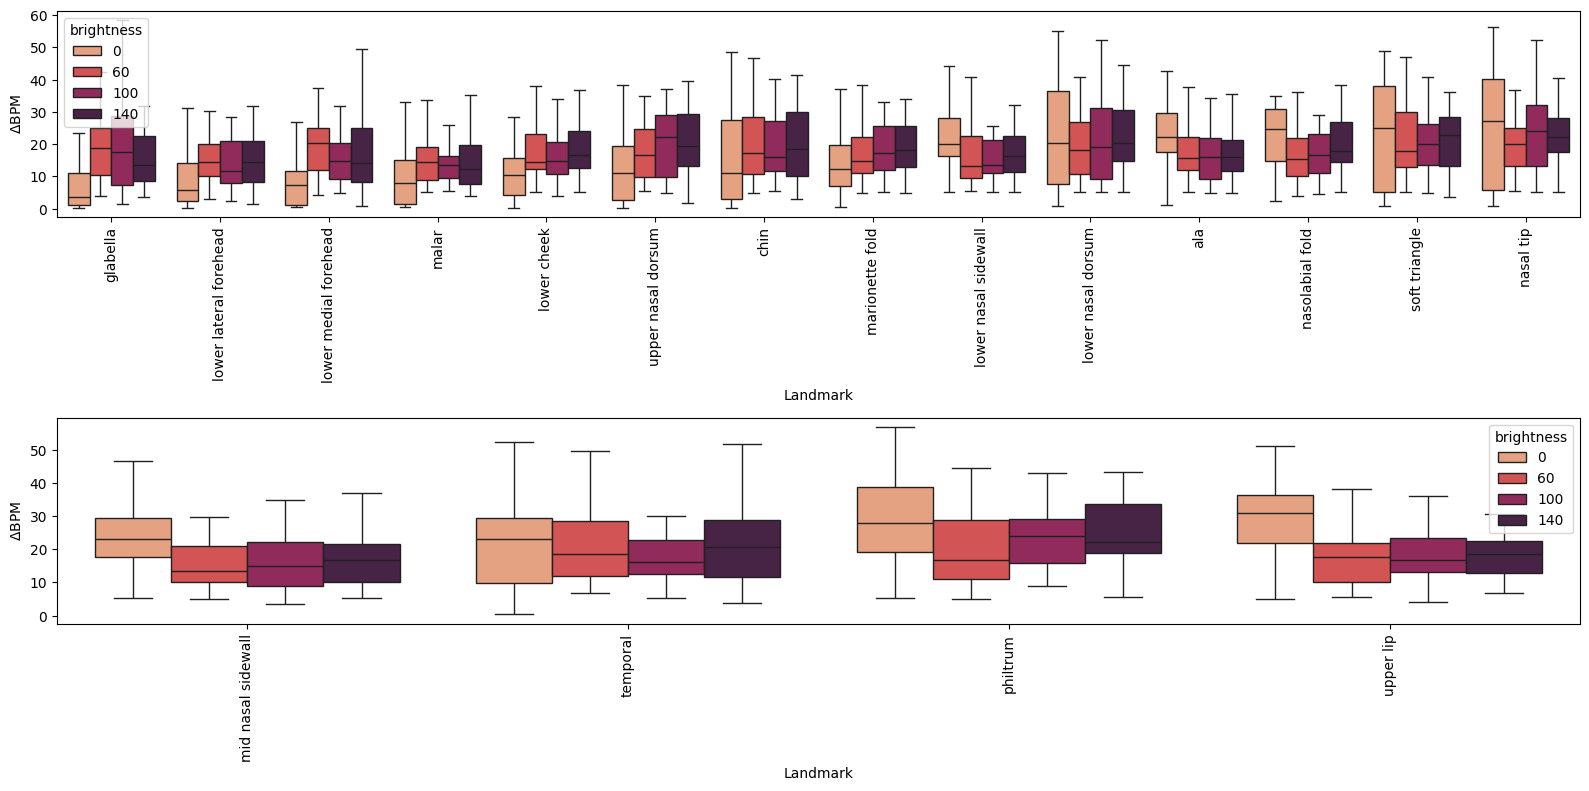

In [14]:
# MOTION
df, grouped, fig = compare_landmarks_brightness(['LGI_PPGI'], still=False)
df[['landmarks', 'brightness','MAE']].groupby(['landmarks', 'brightness']).agg(['mean', 'median']).sort_values(by=('MAE', 'median')).reset_index().groupby('landmarks').head(1) # mean
# df, grouped, fig = compare_landmarks_brightness(['LGI_PPGI'], 'score')
# df[['landmarks', 'brightness','score']].groupby(['landmarks', 'brightness']).agg(['mean', 'median']).sort_values(by=('score', 'median')).reset_index().groupby('landmarks').head(1) # mean
# grouped.reset_index().sort_values(by='MAE').drop_duplicates(subset='landmarks', keep='first') # median
# df[['landmarks', 'brightness','MAE']].groupby(['landmarks', 'brightness']).apply('mean').reset_index().sort_values(by=['landmarks','brightness']).query('landmarks == "marionette_fold"') # check

Brightness levels:  [  0  60 100 140]


landmarks brightness        MAE           
                                            mean     median
0                 glabella          0   4.937024   1.617733
1       upper_nasal_dorsum          0   6.145506   1.989199
2    lower_medial_forehead          0   5.733900   1.997826
3            soft_triangle          0   6.228726   2.341527
4                    malar          0   5.057513   2.540502
5   lower_lateral_forehead          0   5.492145   2.861984
6                nasal_tip          0   7.738701   3.160957
7                     chin          0   6.452267   3.512233
8          nasolabial_fold          0   7.278345   4.120063
9              lower_cheek          0   6.384852   4.170129
10      lower_nasal_dorsum          0   8.473298   4.317998
11         marionette_fold          0   7.858541   4.549334
12                     ala          0   7.802604   4.588219
13    lower_nasal_sidewall          0   8.586757   5.144328
15                philtrum          0  13.162861   7.963332
23      mid_nasal_sidewall          0  11.177232  10.940316
35               upper_lip          0  17.437948  13.887821
38                temporal          0  15.561796  14.199749

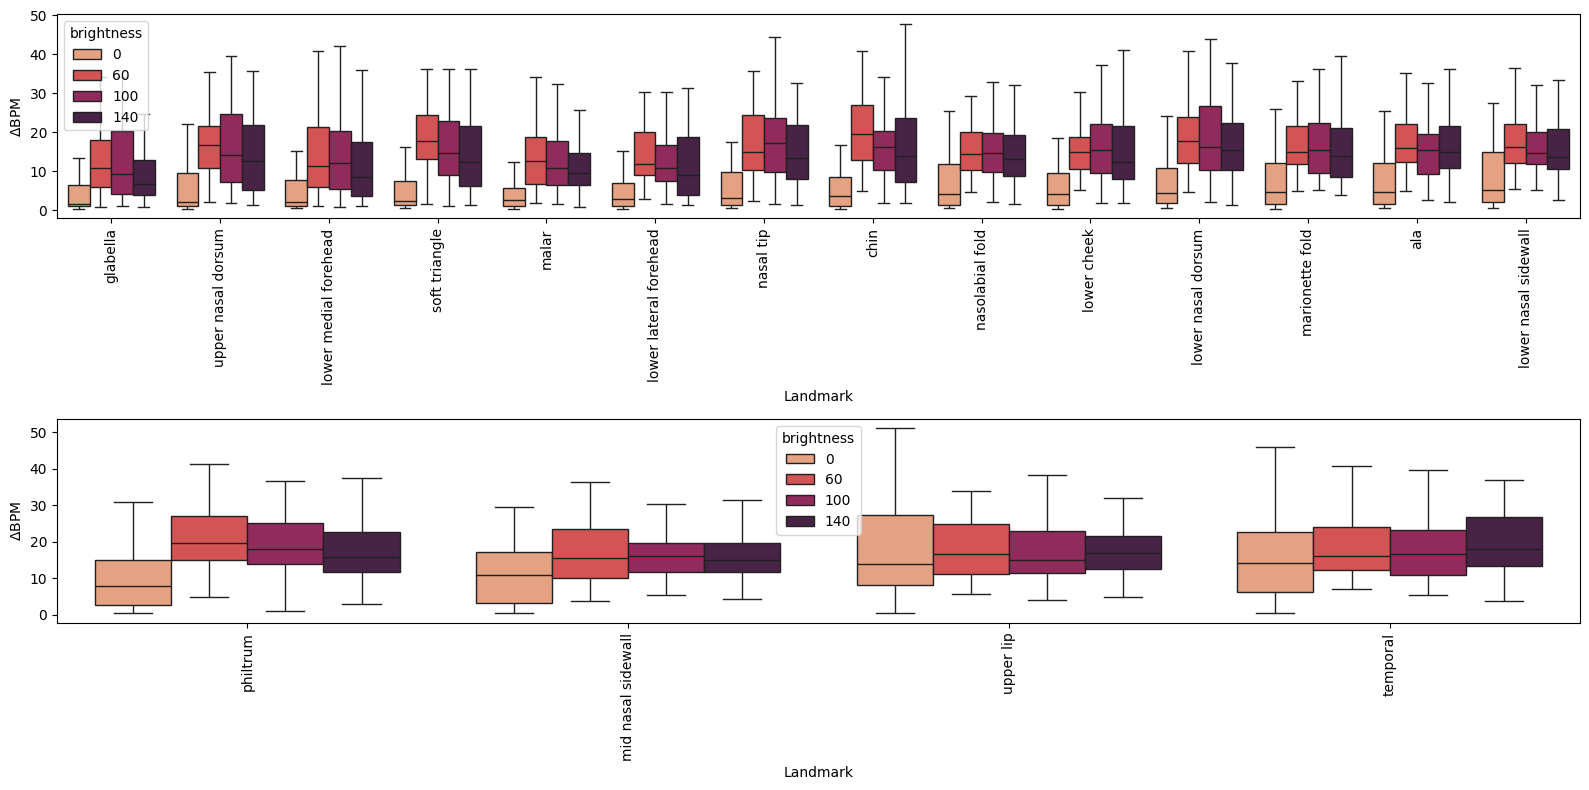

In [15]:
# STILL
df, grouped, fig = compare_landmarks_brightness(DATASETS, still=True)
df[['landmarks', 'brightness','MAE']].groupby(['landmarks', 'brightness']).agg(['mean', 'median']).sort_values(by=('MAE', 'median')).reset_index().groupby('landmarks').head(1) # mean
# grouped.reset_index().sort_values(by='MAE').drop_duplicates(subset='landmarks', keep='first') # median
# df[['landmarks', 'brightness','MAE']].groupby(['landmarks', 'brightness']).apply('mean').reset_index().sort_values(by=['landmarks','brightness']).query('landmarks == "marionette_fold"') # check

Sampling - window - overlap:  ['2000_win10-0']
(396, 22) ROI:  ['forehead' 'nose' 'mustache' 'temple' 'cheeks' 'jaw'] 6
Landmarks:  18


<Axes: title={'center': 'MAE'}, xlabel='videoFilename'>

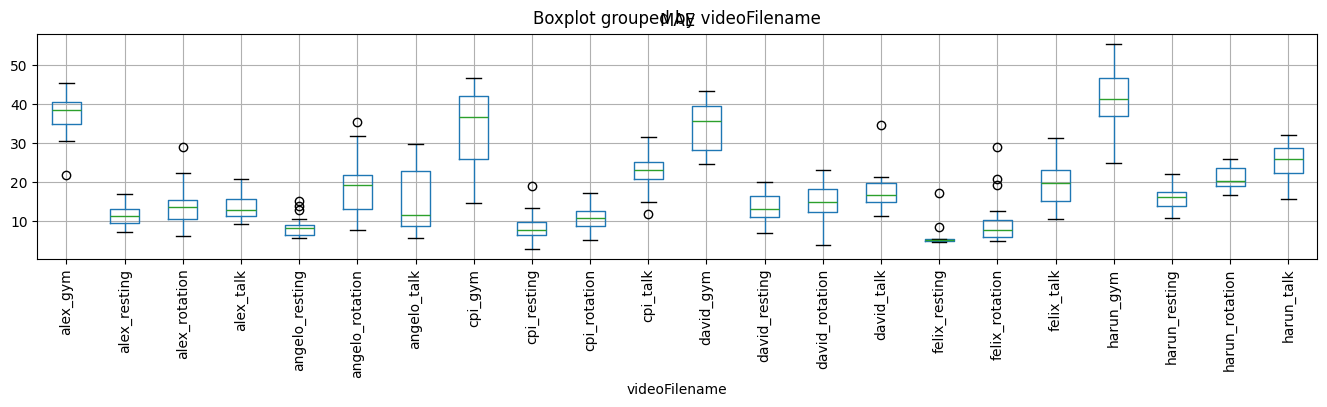

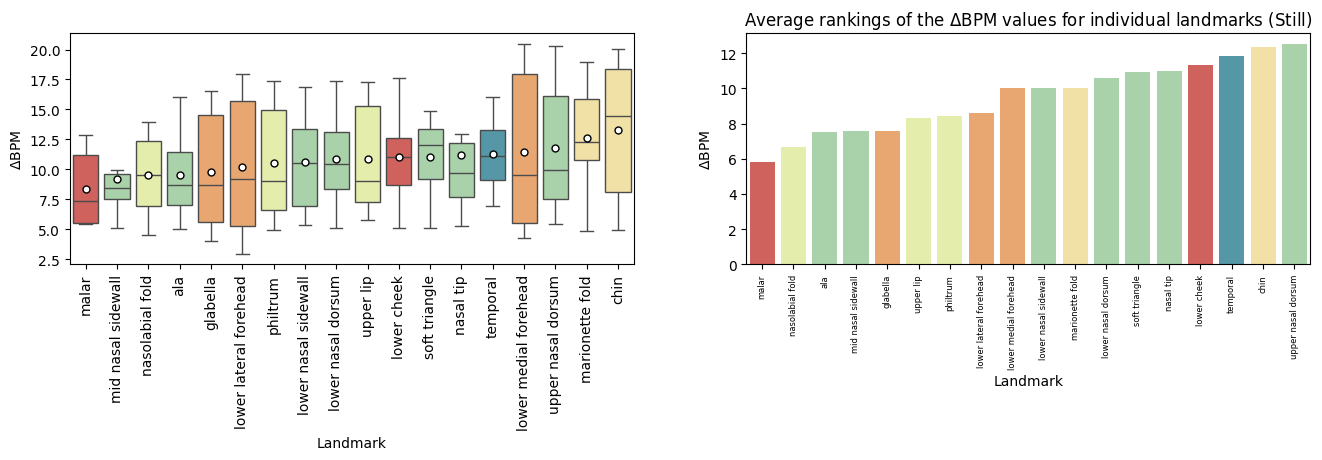

In [18]:
df = pd.read_hdf(f'../results/brightness_60/LGI_PPGI/LGI_PPGI_18.h5')
print("Sampling - window - overlap: ", df.config.unique())
df = df.query("method == 'cupy_CHROM'") # TODO
df = format_data(df).drop(columns=['config', 'MAE_z', 'PCC_z', 'timePCC_z', 'timeDTW_z', ])
df = format_data_symmetric_landmark(df, symmetric=True) 
print(df.shape, "ROI: ", df.ROI.unique(), df.ROI.unique().size)
print("Landmarks: ", df.landmarks.unique().size)
df.head(1)

display(df.boxplot(column='MAE', by='videoFilename', figsize=(16,3), rot=90))

# Still
setting = 'Still'
x = get_still(df)

fig, axs = plt.subplots(1,2, figsize=(16,3))
_, grouped1, rankings1, _, _ = plot_each_landmark(x.copy(), 'MAE', dataset_name=setting, axs=axs)

## Combinations

In [31]:
import steps
elements =  ['glabella', 'upper_nasal_dorsum', 'lower_medial_forehead',
       'soft_triangle', 'malar', 'lower_lateral_forehead', 'nasal_tip', 'chin',
       'nasolabial_fold', 'lower_cheek',
       'marionette_fold', 'ala', ]
all_ldmks = list(CustomLandmarks().get_all_landmarks().keys())
ldmk_names_dict = {ldmk.replace('left_', '').replace('right_', ''): ldmk for ldmk in all_ldmks} # name without left right: name with right
elements = [ldmk_names_dict[ldmk] for ldmk in elements]
for ldmk in elements:
    if 'right_' in ldmk:
        elements.append(ldmk.replace('right', 'left'))
all_landmarks_names = vhr.extraction.utils.CustomLandmarks().get_all_landmarks()
elements = {i: all_landmarks_names[i] for i in elements}
all_landmarks, landmarks_keys = steps.get_landmarks('combine_random_landmarks', min_len=1, max_len=5, all_landmarks_names=elements, rois=None)

# make a dataframe from all_landmarks
tmp = pd.DataFrame( [[x] for x in all_landmarks], columns=['landmarks'])
tmp['landmarks'] = tmp['landmarks'].apply(lambda x: tuple(sorted(x)))
# tmp['landmarks'] = tmp['landmarks'].apply(lambda x: set((x)))
print(tmp.shape, tmp.landmarks.unique().size)

(1585, 1) 1585


24 videos, 1585 landmarks, (36462, 29)
Number of different landmarks combination 1585


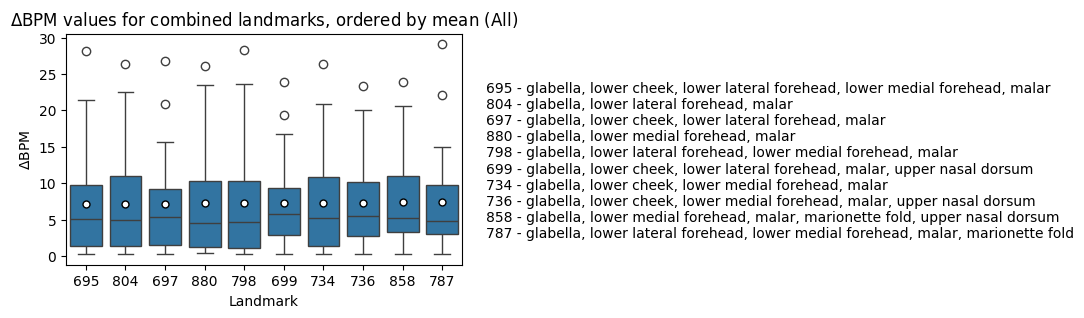

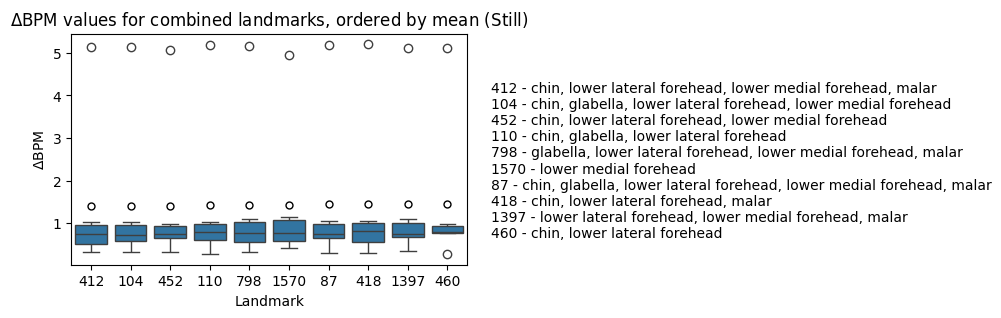

In [44]:
df = pd.DataFrame()
dataset_name = 'LGI_PPGI'
df = pd.concat([df, pd.read_hdf(f'../results/no_overlap/{dataset_name}/{SAMPLING}/{dataset_name}_18.h5')])
df = pd.concat([df, pd.read_hdf(f'../results/no_overlap/{dataset_name}/{SAMPLING}/{dataset_name}_combine_top_landmarks.h5')])
df = pd.concat([df, pd.read_hdf(f'../results/no_overlap/{dataset_name}/{SAMPLING}/{dataset_name}_combine_landmarks_others.h5')])
df = pd.concat([df, pd.read_hdf(f'../results/no_overlap/{dataset_name}/{SAMPLING}/{dataset_name}_combine_landmarks.h5')])

df = df.query("method == 'cupy_CHROM'") # no need to do this but for fun
df['landmarks'] = df['landmarks'].apply(lambda x: tuple(sorted(x)))
df = df[df['landmarks'].isin(tmp.landmarks.unique())]
df = format_data(df)
df['ROI'] = df['ROI'].apply(lambda x: '_'.join(sorted(x.split('_')))) # Sort ROI 

df = df.reset_index(drop=True).drop(columns=['bpmGT', 'bpmES', 'timeGT', 'timeES',])
df['landmarks_id'] = df['landmarks'].astype('category').cat.codes
df['landmarks_names'] = df['landmarks'].apply(lambda x: set([name.replace('left_', '').replace('right_', '').strip() for name in x]))
df['landmarks_len'] = df['landmarks_names'].apply(lambda x: len(x))

print(f"{df.videoIdx.unique().size} videos, {df.landmarks.unique().size} landmarks, {df.shape}")
print("Number of different landmarks combination", df.landmarks_id.unique().size)
df.head(1)

fig, ax = plt.subplots(1,1, figsize=(8,3))
y = analyze_comb.plot_metric_rank2(df, 'MAE', 'All', groupby_col='landmarks_id', top=10, agg_fct='mean', ax=ax, fig=fig)
x = df[(df['dataset'] == 'lgi_ppgi') & df['videoFilename'].str.contains('resting') | (df['dataset'] == 'mr_nirp') | (df['dataset'] == 'ubfc_phys')].copy().reset_index(drop=True)
fig, ax = plt.subplots(1,1, figsize=(8,3))
y = analyze_comb.plot_metric_rank2(x, 'MAE', 'Still', groupby_col='landmarks_id', top=10, agg_fct='mean', ax=ax, fig=fig)

In [45]:
df = pd.DataFrame()
dataset_name = 'LGI_PPGI'
df = pd.concat([df, pd.read_hdf(f'../results/brightness_roi/lgi_mr/{dataset_name}/{dataset_name}_18.h5')])
df = pd.concat([df, pd.read_hdf(f'../results/brightness_roi/lgi_mr/{dataset_name}/{dataset_name}_combine_landmarks_2-6.h5')])
df = df.query("method == 'cupy_CHROM'") # no need to do this but for fun
df['landmarks'] = df['landmarks'].apply(lambda x: tuple(sorted(x)))
df = format_data(df)
df['ROI'] = df['ROI'].apply(lambda x: '_'.join(sorted(x.split('_')))) # Sort ROI 
df = df[~df['landmarks'].apply(lambda x:
                              'lower_nasal_dorsum' in x or 'left_ala' in x or 'left_nasolabial_fold' in x or 'left_temporal' in x)].reset_index(drop=True)
# marionette fold not combined with lower nasal dorsum, ala, nasolabial fold
# 6-11 does not contain temporal, marionette fold
df = df.reset_index(drop=True).drop(columns=['bpmGT', 'bpmES', 'timeGT', 'timeES',])
df['landmarks_id'] = df['landmarks'].astype('category').cat.codes
df['landmarks_names'] = df['landmarks'].apply(lambda x: set([name.replace('left_', '').replace('right_', '').strip() for name in x]))
df['landmarks_len'] = df['landmarks_names'].apply(lambda x: len(x))

print(f"{df.videoIdx.unique().size} videos, {df.landmarks.unique().size} landmarks, {df.shape}")
print("Number of different landmarks combination", df.landmarks_id.unique().size)
df.head(1)

24 videos, 470 landmarks, (11280, 26)
Number of different landmarks combination 470


,dataset,videoIdx,videoFilename,landmarks,BVP_win,RMSE,MAE,PCC,timePCC,timeDTW,...,PCC_z,timePCC_z,timeDTW_z,FreqScore,TimeScore,score,OS,landmarks_id,landmarks_names,landmarks_len
0,lgi_ppgi,0,alex_gym,"(lower_medial_forehead,)","[[[-0.07286111481630266, -2.520903143889549, -...",[35.6402554869851],29.854167,0.276053,0.157236,2.519513,...,0.723947,0.734199,0.607709,0.589213,0.670954,0.531093,0.598795,461,{lower_medial_forehead},1


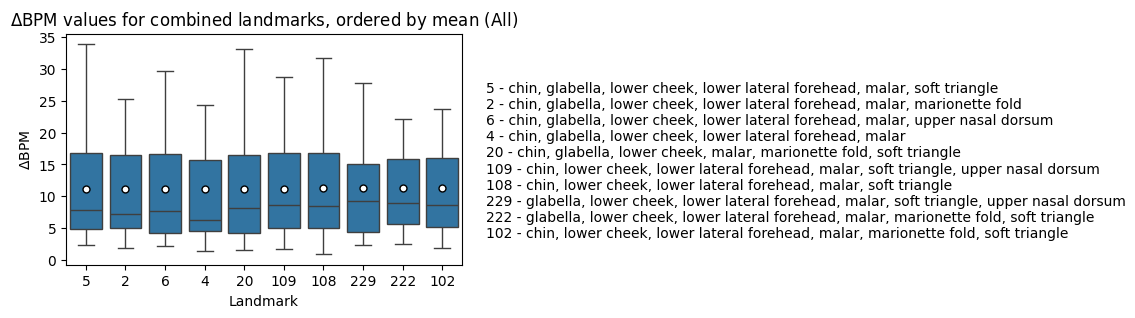

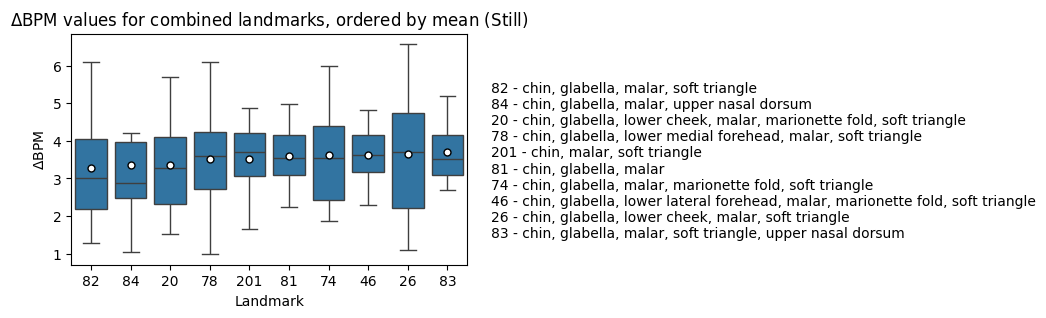

In [46]:
def plot_metric_rank2(df, metric, dataset_name, groupby_col='landmarks_id', top=10, agg_fct='mean', ax=None, fig=None):
    """ 
        Rank by overal mean/median metric and top 10. Plot metric. 
    """
    ascending = False if metric == 'PCC' else True 
    y = df.groupby([groupby_col, 'landmarks', 'ROI'])[metric].agg(['median','mean','std']).sort_values(by=agg_fct, ascending=ascending)[:top].reset_index()
    z = df[df[groupby_col].isin(y[groupby_col].unique())]
    if ax is None:
        return y

    box = sns.boxplot(x=groupby_col, y=metric, order=y.landmarks_id, data=z, showmeans=True, meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black", "markersize":"5"}, showfliers=False)
    # box = sns.violinplot(x=groupby_col, y=metric,  order=y.landmarks_id, data=z, ax=ax)
    # box.legend_.remove()
    landmarks_mapping = y.sort_values(by=agg_fct, ascending=ascending)[['landmarks','landmarks_id']].drop_duplicates()
    landmarks_names = []
    for names in landmarks_mapping['landmarks'].values:
        names = [name.replace('left_', '').replace('right_', '').strip() for name in names]
        landmarks_names.append(', '.join([name.replace('_', ' ') for name in sorted(set(names))]))
    legend_text = '\n'.join(f'{key} - {value}' for key, value in zip(landmarks_mapping['landmarks_id'].values, landmarks_names))
    t = ax.text(.65,.2,legend_text,transform=ax.figure.transFigure)
    fig.subplots_adjust(right=.62)
    if metric == 'MAE': metric = r'$\Delta$' + 'BPM'
    box.set_xlabel('Landmark')
    box.set_ylabel(metric)
    title = f"{metric} values for combined landmarks, ordered by {agg_fct} ({dataset_name})"
    box.set_title(title)
    return y 

fig, ax = plt.subplots(1,1, figsize=(8,3))
y = plot_metric_rank2(df, 'MAE', 'All', groupby_col='landmarks_id', top=10, agg_fct='mean', ax=ax, fig=fig)
x = df[(df['dataset'] == 'lgi_ppgi') & df['videoFilename'].str.contains('resting') | (df['dataset'] == 'mr_nirp') | (df['dataset'] == 'ubfc_phys')].copy().reset_index(drop=True)
fig, ax = plt.subplots(1,1, figsize=(8,3))
y = plot_metric_rank2(x, 'MAE', 'Still', groupby_col='landmarks_id', top=10, agg_fct='mean', ax=ax, fig=fig)

## Change soft triangle

In [47]:
df = pd.DataFrame()
dataset_name = 'LGI_PPGI'
df = pd.concat([df, pd.read_hdf(f'../results/brightness_roi/lgi_mr/{dataset_name}/{dataset_name}_18.h5')])
df = pd.concat([df, pd.read_hdf(f'../results/brightness_roi/lgi_mr/{dataset_name}/{dataset_name}_combine_landmarks_new_soft_triangle.h5')])
df = df.query("method == 'cupy_CHROM'") # no need to do this but for fun
df['landmarks'] = df['landmarks'].apply(lambda x: tuple(sorted(x)))
df = format_data(df)
df['ROI'] = df['ROI'].apply(lambda x: '_'.join(sorted(x.split('_')))) # Sort ROI 
df = df[~df['landmarks'].apply(lambda x:
                              'chin' in x or 'left_marionette_fold' in x or 'left_lower_cheek' in x or 'left_temporal' in x)].reset_index(drop=True)
# marionette fold not combined with lower nasal dorsum, ala, nasolabial fold
# 6-11 does not contain temporal, marionette fold
df = df.reset_index(drop=True).drop(columns=['bpmGT', 'bpmES', 'timeGT', 'timeES',])
df['landmarks_id'] = df['landmarks'].astype('category').cat.codes
df['landmarks_names'] = df['landmarks'].apply(lambda x: set([name.replace('left_', '').replace('right_', '').strip() for name in x]))
df['landmarks_len'] = df['landmarks_names'].apply(lambda x: len(x))

print(f"{df.videoIdx.unique().size} videos, {df.landmarks.unique().size} landmarks, {df.shape}")
print("Number of different landmarks combination", df.landmarks_id.unique().size)
df.head(1)

24 videos, 45 landmarks, (1080, 26)
Number of different landmarks combination 45


,dataset,videoIdx,videoFilename,landmarks,BVP_win,RMSE,MAE,PCC,timePCC,timeDTW,...,PCC_z,timePCC_z,timeDTW_z,FreqScore,TimeScore,score,OS,landmarks_id,landmarks_names,landmarks_len
0,lgi_ppgi,0,alex_gym,"(lower_medial_forehead,)","[[[-0.07286111481630266, -2.520903143889549, -...",[35.6402554869851],29.854167,0.276053,0.157236,2.519513,...,0.723947,0.693823,0.650352,0.589722,0.672087,0.552924,0.599891,36,{lower_medial_forehead},1


In [48]:
# To compare with brighter version

## Still
metric, agg_fct, ascending = 'MAE', 'mean', True
x = df[(df['dataset'] == 'lgi_ppgi') & df['videoFilename'].str.contains('resting')].copy().reset_index(drop=True)
y = x.groupby(['landmarks', 'ROI'])[metric].agg(['median','mean','std']).sort_values(by=agg_fct, ascending=ascending).reset_index()
top_comb_idx = y[y['landmarks'].isin([('glabella', 'left_malar', 'right_malar', 'soft_triangle')])].index[0]
display(y.iloc[[0,1,2,top_comb_idx]])

## Motion
metric, agg_fct, ascending = 'MAE', 'mean', True
x = df[(df['dataset'] == 'lgi_ppgi') & ~df['videoFilename'].str.contains('resting')].copy().reset_index(drop=True)
y = x.groupby(['landmarks', 'ROI'])[metric].agg(['median','mean','std']).sort_values(by=agg_fct, ascending=ascending).reset_index()
top_comb_idx = y[y['landmarks'].isin([('glabella', 'left_malar', 'right_malar', 'soft_triangle')])].index[0]
display(y.iloc[[0,1,2,top_comb_idx]])

## All
metric, agg_fct, ascending = 'MAE', 'mean', True
x = df[(df['dataset'] == 'lgi_ppgi')].copy().reset_index(drop=True)
y = x.groupby(['landmarks', 'ROI'])[metric].agg(['median','mean','std']).sort_values(by=agg_fct, ascending=ascending).reset_index()
top_comb_idx = y[y['landmarks'].isin([('glabella', 'left_malar', 'right_malar', 'soft_triangle')])].index[0]
display(y.iloc[[0,1,2,top_comb_idx]])

,landmarks,ROI,median,mean,std
0,"(left_lower_lateral_forehead, left_malar, lowe...",cheeks_forehead_nose,0.639323,1.232422,1.428423
1,"(glabella, left_lower_lateral_forehead, left_m...",cheeks_forehead_nose,0.668387,1.244048,1.447659
2,"(glabella, left_lower_lateral_forehead, left_m...",cheeks_forehead_nose,0.659668,1.259549,1.457857
9,"(glabella, left_malar, right_malar, soft_trian...",cheeks_forehead_nose,0.715251,1.374295,1.527662


,landmarks,ROI,median,mean,std
0,"(glabella, left_lower_lateral_forehead, left_m...",cheeks_forehead_nose,7.827637,10.391798,8.052575
1,"(glabella, left_lower_lateral_forehead, left_m...",cheeks_forehead_nose,7.499116,10.560549,8.340569
2,"(glabella, left_lower_lateral_forehead, left_m...",cheeks_forehead_nose,8.298782,10.651494,8.550478
15,"(glabella, left_malar, right_malar, soft_trian...",cheeks_forehead_nose,11.284342,12.543633,8.509372


,landmarks,ROI,median,mean,std
0,"(glabella, left_lower_lateral_forehead, left_m...",cheeks_forehead_nose,4.751383,8.128657,8.024993
1,"(glabella, left_lower_lateral_forehead, left_m...",cheeks_forehead_nose,5.115327,8.261942,8.270398
2,"(glabella, left_lower_lateral_forehead, left_m...",cheeks_forehead_nose,5.429222,8.299632,8.474027
15,"(glabella, left_malar, right_malar, soft_trian...",cheeks_forehead_nose,8.574788,9.751299,8.856396


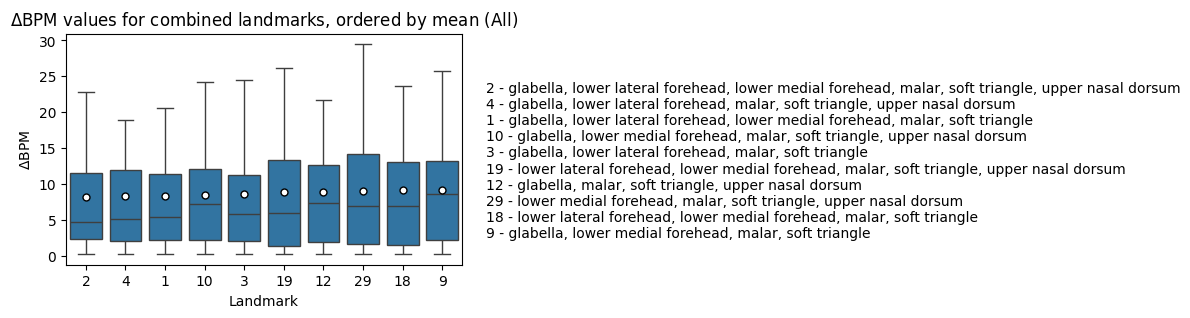

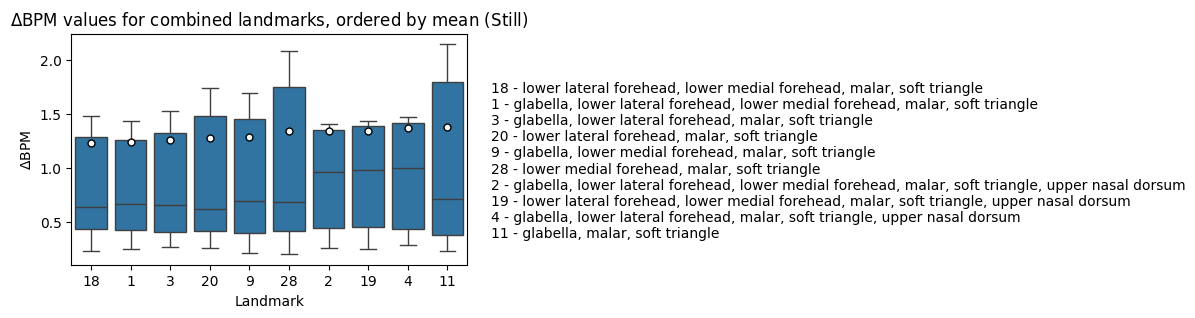

In [49]:
fig, ax = plt.subplots(1,1, figsize=(8,3))
y = plot_metric_rank2(df, 'MAE', 'All', groupby_col='landmarks_id', top=10, agg_fct='mean', ax=ax, fig=fig)
x = df[(df['dataset'] == 'lgi_ppgi') & df['videoFilename'].str.contains('resting') | (df['dataset'] == 'mr_nirp') | (df['dataset'] == 'ubfc_phys')].copy().reset_index(drop=True)
fig, ax = plt.subplots(1,1, figsize=(8,3))
y = plot_metric_rank2(x, 'MAE', 'Still', groupby_col='landmarks_id', top=10, agg_fct='mean', ax=ax, fig=fig)

## Just changed soft triangle

In [ ]:
setting = 'roi_80'
df = pd.DataFrame()
for dataset_name in DATASETS:
    df = pd.concat([df, pd.read_hdf(f'../results/brightness_roi//{setting}/{dataset_name}_GMS.h5')])
df['landmarks'] = df['landmarks'].apply(lambda x: tuple(sorted(x)))
df = format_data(df)
df['ROI'] = df['ROI'].apply(lambda x: '_'.join(sorted(x.split('_')))) # Sort ROI 
df = df.reset_index(drop=True).drop(columns=['bpmGT', 'bpmES', 'timeGT', 'timeES',])
df['landmarks_id'] = df['landmarks'].astype('category').cat.codes
df['landmarks_names'] = df['landmarks'].apply(lambda x: set([name.replace('left_', '').replace('right_', '').strip() for name in x]))
df['landmarks_len'] = df['landmarks_names'].apply(lambda x: len(x))

print(f"{df.videoIdx.unique().size} videos, {df.landmarks.unique().size} landmarks, {df.shape}")
print("Number of different landmarks combination", df.landmarks_id.unique().size)
df.head(1)

72 videos, 1 landmarks, (88, 26)
Number of different landmarks combination 1


,dataset,videoIdx,videoFilename,landmarks,BVP_win,RMSE,MAE,PCC,timePCC,timeDTW,...,PCC_z,timePCC_z,timeDTW_z,FreqScore,TimeScore,score,OS,landmarks_id,landmarks_names,landmarks_len
0,lgi_ppgi,0,alex_gym,"(glabella, left_malar, right_malar, soft_trian...","[[[0.06878939782788085, -1.723668941569227, -3...",[25.910477819756796],23.870443,0.453401,0.06044,2.152949,...,0.548749,0.915337,0.467226,0.62205,0.691282,0.581289,0.692638,0,"{glabella, soft_triangle, malar}",3


In [ ]:
# To compare with brighter version

## Still
metric, agg_fct, ascending = 'MAE', 'mean', True
x = df[(df['dataset'] == 'lgi_ppgi') & df['videoFilename'].str.contains('resting') | (df['dataset'] == 'mr_nirp') & df['videoFilename'].str.contains('still') | (df['dataset'] == 'ubfc_phys')].copy().reset_index(drop=True)
y = x.groupby(['landmarks', 'ROI'])[metric].agg(['median','mean','std']).sort_values(by=agg_fct, ascending=ascending).reset_index()
display(y)

## Motion
metric, agg_fct, ascending = 'MAE', 'mean', True
x = df[(df['dataset'] == 'lgi_ppgi') & ~df['videoFilename'].str.contains('resting')].copy().reset_index(drop=True)
y = x.groupby(['landmarks', 'ROI'])[metric].agg(['median','mean','std']).sort_values(by=agg_fct, ascending=ascending).reset_index()
display(y)

## All
metric, agg_fct, ascending = 'MAE', 'mean', True
y = df.groupby(['landmarks', 'ROI'])[metric].agg(['median','mean','std']).sort_values(by=agg_fct, ascending=ascending).reset_index()
display(y)

,landmarks,ROI,median,mean,std
0,"(glabella, left_malar, right_malar, soft_trian...",cheeks_forehead_nose,4.601285,7.150547,7.840932


,landmarks,ROI,median,mean,std
0,"(glabella, left_malar, right_malar, soft_trian...",cheeks_forehead_nose,12.604533,14.12165,7.953562


,landmarks,ROI,median,mean,std
0,"(glabella, left_malar, right_malar, soft_trian...",cheeks_forehead_nose,6.229309,8.576455,8.313782


## Compare performance

In [51]:
def __get_df(df):
    df = format_data(df).drop(columns=['config', 'MAE_z', 'PCC_z', 'timePCC_z', 'timeDTW_z', ])
    df = format_data_symmetric_landmark(df, symmetric=True) 
    df['ldmk_MAE'] = df.groupby(['landmarks'])['MAE'].transform('mean')
    df['video_MAE'] = df.groupby(['videoFilename'])['MAE'].transform('mean') 
    return df

def __get_diff(df, dataset_name, groupby_col, metric):
    """
        groupby_col = 'videoFilename':  metric average for each video and brightness (over all landmarks)
        groupby_col = 'landmarks':  metric average for each landmark and brightness (over all videos)
    """
    diff = df.groupby([groupby_col, 'brightness'])[metric].mean().unstack() # metric for each video and brightness (all)
    diff['best'] = diff.idxmin(axis=1)
    diff['best'] = diff['best'].apply(lambda x: int(x))
    if groupby_col == 'videoFilename':
        x = pd.read_csv(f'../results/no_overlap/{dataset_name}/face_brightness.csv')
        diff = diff.merge(x.drop(columns=['dataset']), on='videoFilename', how='left') 

    return diff

def compare_brightness(dataset_name):
    df = __get_df(pd.read_hdf(f'../results/no_overlap/{dataset_name}/{SAMPLING}/{dataset_name}_18.h5').query("method == 'cupy_CHROM'"))
    df['brightness'] = 0
    df = get_pruned(df)
    levels = [60,100, 140]
    for level in levels:
        tmp = __get_df(pd.read_hdf(f'../results/brightness_{level}/{dataset_name}/{dataset_name}_18.h5'))
        tmp['brightness'] = level
        df = pd.concat([df, tmp], ignore_index=True) 
    video_diff = __get_diff(df,dataset_name, 'videoFilename', 'MAE')
    landmark_diff = __get_diff(df,dataset_name, 'landmarks', 'MAE')
    display(video_diff.loc[video_diff['best'] > 0])
    display(landmark_diff.loc[landmark_diff['best'] > 0])

    return video_diff, landmark_diff

In [ ]:
df_all = pd.DataFrame()
for dataset_name in DATASETS:
    df = __get_df(pd.read_hdf(f'../results/no_overlap/{dataset_name}/{SAMPLING}/{dataset_name}_18.h5').query("method == 'cupy_CHROM'"))
    df['level'] = 0
    levels = [60,100, 140]
    for level in levels:
        tmp = __get_df(pd.read_hdf(f'../results/brightness_{level}/{dataset_name}/{dataset_name}_18.h5'))
        tmp['level'] = level
        df = pd.concat([df, tmp], ignore_index=True) 
    x = pd.read_csv(f'../results/no_overlap/{dataset_name}/face_brightness.csv')
    df = df.merge(x.drop(columns=['dataset']), on='videoFilename', how='left') 
    df_all = pd.concat([df_all, df], ignore_index=True) 

df_all['brightness'] = np.where(df_all['level'] == 0, df_all['brightness'], df_all['level'])


In [ ]:
bins = range(20, 160, 20)  # Define bins from 0 to 100 with a step of 20
labels = [f'{i}-{i+20}' for i in bins[:-1]]  # Labels for the bins
metric = 'MAE'
df_all['brightness_group'] = pd.cut(df_all['brightness'], bins=bins, labels=labels, right=False)
diff = df_all.groupby(['videoFilename', 'landmarks', 'brightness_group'])[metric].apply('min').unstack() # metric for each video and brightness (all)
diff['best'] = diff.idxmin(axis=1)
ldmk_bin = diff.groupby('landmarks')['best'].value_counts().reset_index(name='count')
nb_files_group = df_all['brightness_group'].value_counts()
ldmk_bin['total'] = (ldmk_bin['best'].map(nb_files_group)).astype(int)
ldmk_bin['frac'] = ldmk_bin['count'] / ldmk_bin['total']

In [ ]:
pd.crosstab(index=ldmk_bin['landmarks'], columns=ldmk_bin['best'], values=ldmk_bin['count'], aggfunc='sum', normalize='index').style.background_gradient(cmap='viridis', axis=1)

best,20-40,40-60,60-80,80-100,100-120,120-140
landmarks,,,,,,
ala,0.011364,0.011364,0.181818,0.056818,0.420455,0.318182
chin,0.011364,0.022727,0.170455,0.068182,0.340909,0.386364
glabella,0.011364,0.022727,0.238636,0.056818,0.340909,0.329545
lower_cheek,0.011364,0.022727,0.204545,0.090909,0.295455,0.375000
lower_lateral_forehead,0.011364,0.034091,0.159091,0.079545,0.363636,0.352273
lower_medial_forehead,0.011364,0.022727,0.170455,0.056818,0.397727,0.340909
lower_nasal_dorsum,0.011364,0.034091,0.227273,0.068182,0.340909,0.318182
lower_nasal_sidewall,0.011364,0.022727,0.204545,0.068182,0.397727,0.295455
malar,0.011364,0.022727,0.159091,0.056818,0.352273,0.397727


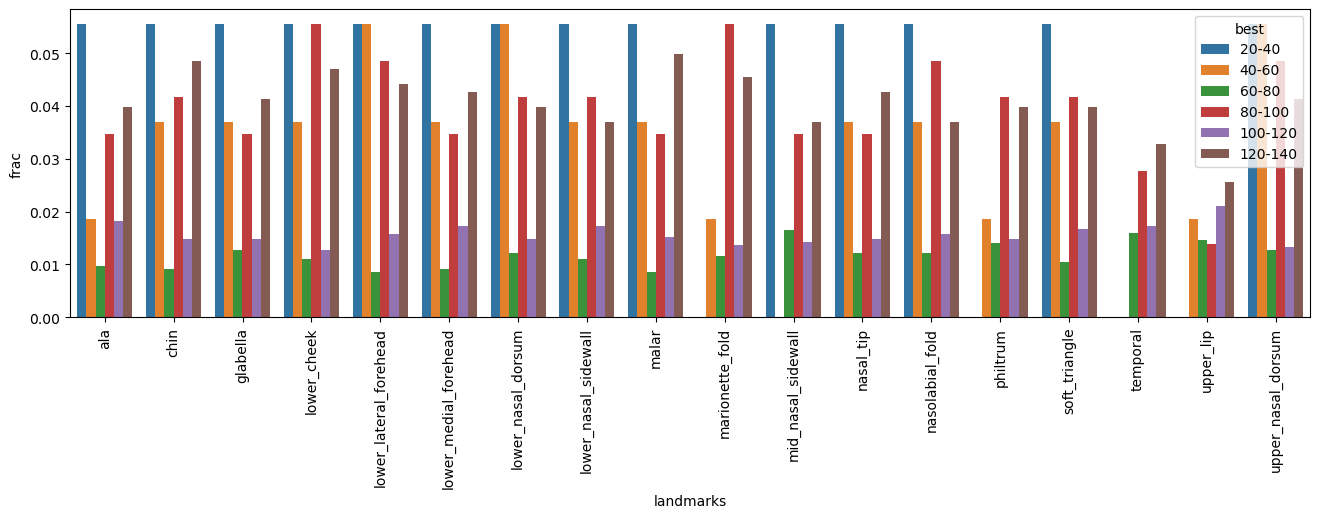

In [ ]:
plt.figure(figsize=(16,4))
sns.barplot(data=ldmk_bin, x='landmarks', y='frac', hue='best')
plt.xticks(rotation=90)
plt.show()

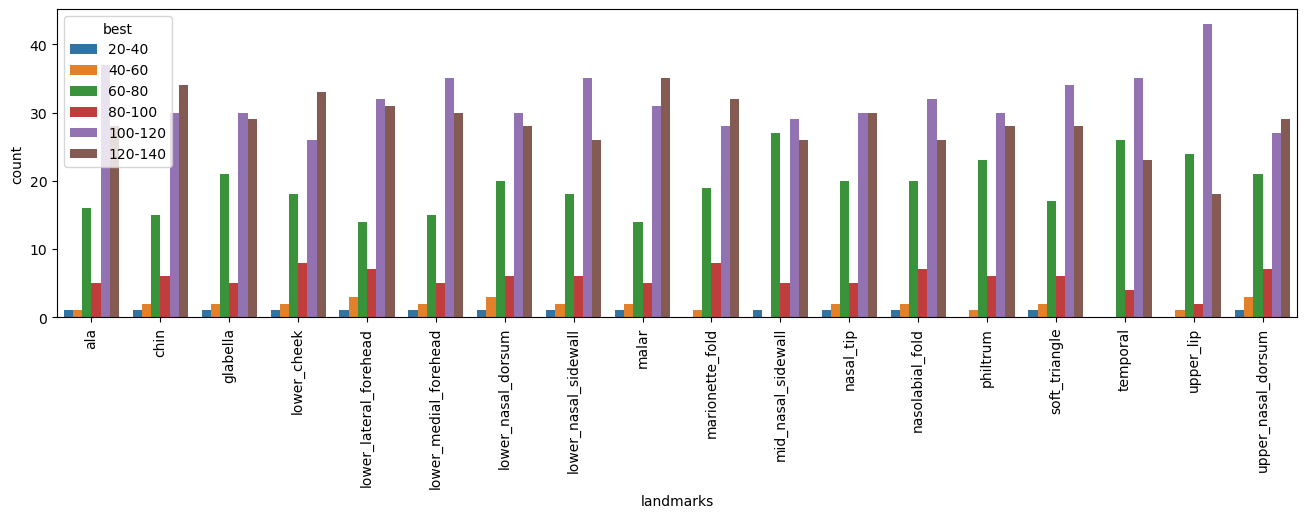

In [ ]:
plt.figure(figsize=(16,4))
sns.barplot(data=ldmk_bin, x='landmarks', y='count', hue='best')
plt.xticks(rotation=90)
plt.show()

In [ ]:
dataset_name = 'LGI_PPGI'
df = __get_df(pd.read_hdf(f'../results/no_overlap/{dataset_name}/{SAMPLING}/{dataset_name}_18.h5').query("method == 'cupy_CHROM'"))
df['brightness'] = 20
levels = [60,100]
for level in levels:
    tmp = __get_df(pd.read_hdf(f'../results/brightness_{level}/{dataset_name}/{dataset_name}_18.h5'))
    tmp['brightness'] = level
    df = pd.concat([df, tmp], ignore_index=True) 

In [ ]:
# for each video and landmark, best brightness
groupby_col = 'videoFilename'
metric = 'MAE'
diff = df.groupby([groupby_col, 'landmarks', 'brightness'])[metric].apply('min').unstack() # metric for each video and brightness (all)
diff['best'] = diff.idxmin(axis=1).apply(lambda x: int(x))
df = df.sort_values([groupby_col, 'landmarks', 'MAE'])[['videoFilename', 'brightness', 'MAE', 'landmarks']]
df = df.merge(diff['best'], on=['videoFilename', 'landmarks'], how='left').sort_values(['videoFilename', 'landmarks', 'MAE']).drop_duplicates(['videoFilename', 'landmarks'])
x = pd.read_csv(f'../results/no_overlap/{dataset_name}/face_brightness.csv')
df = df.merge(x.drop(columns=['dataset']).rename({'brightness':'video_brightness'}, axis=1), on='videoFilename', how='left') 
df['best_brightness'] = df.apply(lambda x: x['brightness'] if x['best'] > 0 else x['video_brightness'], axis=1)
df['brighter_better'] = df['best'] > 0
df.query('best > 0').drop_duplicates(['videoFilename','landmarks'])

,videoFilename,brightness,MAE,landmarks,best,video_brightness,best_brightness,brighter_better
0,alex_gym,20,23.774414,ala,20,105.685542,20,True
1,alex_gym,20,32.318034,chin,20,105.685542,20,True
2,alex_gym,20,23.451497,glabella,20,105.685542,20,True
3,alex_gym,20,28.348145,lower_cheek,20,105.685542,20,True
4,alex_gym,20,31.319336,lower_lateral_forehead,20,105.685542,20,True
...,...,...,...,...,...,...,...,...
427,harun_talk,20,22.855143,philtrum,20,135.032223,20,True
428,harun_talk,60,30.980143,soft_triangle,60,135.032223,60,True
429,harun_talk,20,6.016764,temporal,20,135.032223,20,True
430,harun_talk,60,19.812012,upper_lip,60,135.032223,60,True


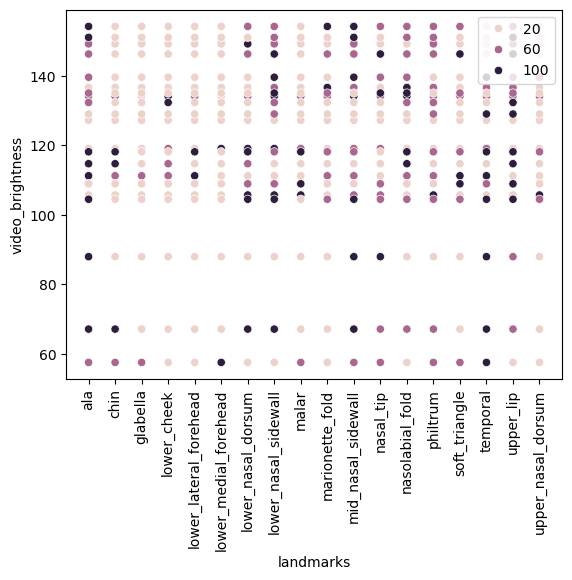

In [ ]:
sns.scatterplot(x='landmarks', y='video_brightness',data=df.query('best > 0'), hue='best')
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.show()

In [ ]:
dataset_name = 'LGI_PPGI'
df = __get_df(pd.read_hdf(f'../results/no_overlap/{dataset_name}/{SAMPLING}/{dataset_name}_18.h5').query("method == 'cupy_CHROM'"))
df['brightness'] = 0
levels = [60,100]
for level in levels:
    tmp = __get_df(pd.read_hdf(f'../results/brightness_{level}/{dataset_name}/{dataset_name}_18.h5'))
    tmp['brightness'] = level
    df = pd.concat([df, tmp], ignore_index=True) 

ldmks = ['lower_lateral_forehead', 'marionette_fold', 'chin', 'lower_medial_forehead', 'upper_nasal_dorsum', 'soft_triangle', 'glabella', 'malar', 'lower_cheek']
# best landmarks: for each video, if the brightned version was best
df.loc[df['landmarks'].isin(ldmks)].sort_values(['videoFilename', 'MAE']).drop_duplicates(['videoFilename'], keep='first').query('brightness > 0')[['videoFilename', 'brightness', 'MAE', 'landmarks']]
# for the best landmarks: for each video, how many times the brightned version was best
# df.loc[df['landmarks'].isin(ldmks)].sort_values(['videoFilename','landmarks',  'MAE']).drop_duplicates(['videoFilename', 'landmarks'], keep='first').query('brightness > 0')[['videoFilename', 'brightness', 'MAE', 'landmarks']]

,videoFilename,brightness,MAE,landmarks
719,felix_resting,60,4.836263,marionette_fold
1135,felix_talk,100,7.650065,lower_lateral_forehead


In [ ]:
# for each video and landmark, best brightness
diff = df.groupby([groupby_col, 'landmarks', 'brightness'])[metric].apply('min').unstack() # metric for each video and brightness (all)
diff['best'] = diff.idxmin(axis=1).apply(lambda x: int(x))
df = df.sort_values([groupby_col, 'landmarks', 'MAE'])[['videoFilename', 'brightness', 'MAE', 'landmarks']]
df = df.merge(diff['best'], on=['videoFilename', 'landmarks'], how='left').sort_values(['videoFilename', 'landmarks', 'MAE'])
df.query('best > 0').drop_duplicates(['videoFilename','landmarks'])

,videoFilename,brightness,MAE,landmarks,best
18,alex_gym,100,35.733398,lower_nasal_dorsum,100
21,alex_gym,100,24.075684,lower_nasal_sidewall,100
24,alex_gym,100,26.024414,malar,100
30,alex_gym,60,21.703613,mid_nasal_sidewall,60
33,alex_gym,60,45.132812,nasal_tip,60
...,...,...,...,...,...
1197,harun_talk,60,17.736816,marionette_fold,60
1203,harun_talk,100,17.627604,nasal_tip,100
1206,harun_talk,100,16.392741,nasolabial_fold,100
1212,harun_talk,60,30.980143,soft_triangle,60


In [ ]:
# min error landmark video
groupby_col = 'videoFilename'
metric = 'MAE'
diff = df.groupby([groupby_col, 'brightness'])[metric].apply('min').unstack() # metric for each video and brightness (all)
diff['best'] = diff.idxmin(axis=1).apply(lambda x: int(x))
df = df.sort_values([groupby_col, 'MAE']).drop_duplicates([groupby_col, 'brightness'], keep='first')[['videoFilename', 'brightness', 'MAE', 'landmarks']]
df = df.merge(diff['best'], on='videoFilename', how='left').sort_values([groupby_col, 'MAE'])
df.query('best > 0').drop_duplicates(groupby_col)

,videoFilename,brightness,MAE,landmarks,best
31,cpi_talk,60,11.777507,ala,60
47,felix_resting,60,4.531087,nasolabial_fold,60
53,felix_talk,100,7.650065,lower_lateral_forehead,100


In [ ]:
dataset_name = 'MR_NIRP'
video_diff, landmark_diff = compare_brightness(dataset_name)

,videoFilename,0,60,100,140,best,brightness


brightness,0,60,100,140,best
landmarks,,,,,
philtrum,25.749593,20.414958,20.248372,20.074626,140
temporal,20.594767,16.469279,16.886759,22.713216,60
upper_lip,30.115967,13.492513,13.585815,16.947469,60


In [ ]:
dataset_name = 'LGI_PPGI'
video_diff, landmark_diff = compare_brightness(dataset_name)

,videoFilename,0,60,100,140,best,brightness
1,alex_resting,15.744548,11.677445,14.918792,13.882351,60,139.583053
2,alex_rotation,14.540500,14.420709,15.939055,14.519170,60,118.735087
3,alex_talk,23.466182,13.615488,18.434579,19.803584,60,134.113538
4,angelo_gym,34.731644,NaN,NaN,34.464392,140,127.194800
6,angelo_rotation,13.056080,18.992414,12.892804,16.248969,100,149.430715
7,angelo_talk,21.671667,14.757577,16.588198,17.736355,60,67.080684
9,cpi_resting,10.009341,8.296342,8.238290,8.684462,100,149.183808
10,cpi_rotation,12.075982,11.182907,12.646756,13.981518,60,151.058641
11,cpi_talk,24.199472,22.385073,25.126121,26.266891,60,57.488957
13,david_resting,16.025933,13.588135,14.014938,14.084500,60,154.209330


brightness,0,60,100,140,best
landmarks,,,,,
ala,22.108480,18.226341,17.375185,18.186293,100
lower_nasal_dorsum,22.659587,19.524902,21.070594,21.690484,60
lower_nasal_sidewall,23.810757,16.980898,17.354218,18.516690,60
mid_nasal_sidewall,23.651815,16.092729,16.394746,17.753330,60
nasal_tip,24.888699,21.354625,23.659535,23.457221,60
nasolabial_fold,21.582038,17.326290,18.817168,19.522983,60
philtrum,29.015964,20.122366,24.114480,25.020128,60
soft_triangle,21.778347,21.790897,20.575447,21.117730,100
temporal,21.208483,20.889301,18.407160,21.186896,100


In [ ]:
dataset_name = 'UBFC_PHYS'
video_diff, landmark_diff = compare_brightness(dataset_name)

,videoFilename,0,60,100,140,best,brightness
6,s15,41.467081,28.449490,28.328514,30.627035,100,126.771056
14,s22,15.117059,14.257035,15.220450,15.868562,60,109.839438
18,s26,34.790191,30.566949,33.141439,33.920166,60,99.090460
26,s33,31.203924,16.633672,21.324508,21.109691,60,129.745947
48,s53,11.662574,12.912607,12.390824,11.519115,140,127.015017
54,s8,15.067380,13.554000,15.880434,15.449345,60,118.323474
55,s9,30.915302,31.029668,29.857359,34.538249,100,136.407247


brightness,0,60,100,140,best
landmarks,,,,,


<AxesSubplot: title={'center': 'UBFC_PHYS'}, xlabel='brightness'>

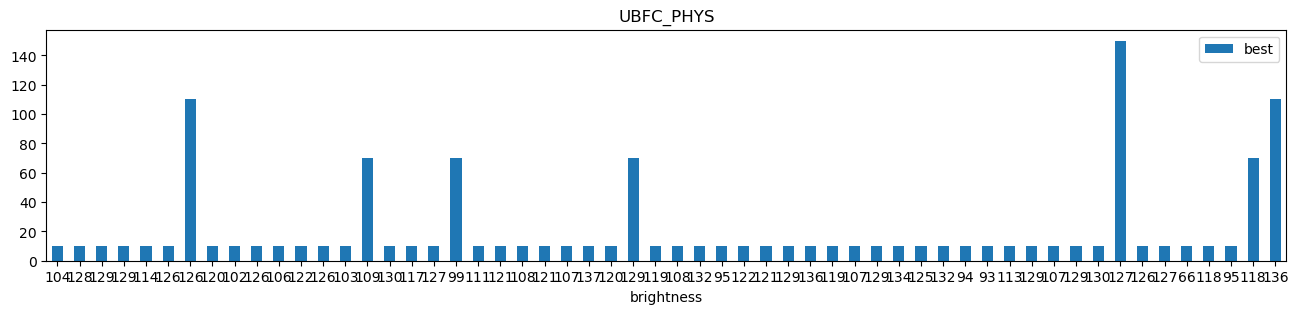

In [ ]:
video_diff['brightness'] = video_diff['brightness'].astype(int)
video_diff['best'] = video_diff['best'] + 10
video_diff.plot(x='brightness', y='best', kind='bar', figsize=(16,3), rot=0, title=dataset_name)

# ROI Brightness

## By window

Same results as by video any fucking ways

In [52]:
import ast 

df_roi, df = pd.DataFrame(), pd.DataFrame()
for dataset_name in DATASETS:
    df_roi = pd.read_csv(f'../results/no_overlap/{dataset_name}/roi_brightness.csv')
    df_video = pd.read_csv(f'../results/no_overlap/{dataset_name}/face_brightness.csv')

    tmp = pd.read_hdf(f'../results/no_overlap/{dataset_name}/{SAMPLING}/{dataset_name}_28.h5').drop(columns=['BVP_win', 'timeGT', 'config'])
    tmp['landmarks'] = tmp['landmarks'].apply(lambda x: x[0])
    # merge df_roi to df by matching values in the column 'landmarks' in df to the column names in df_roi
    tmp = tmp.merge(df_roi.melt(id_vars=['videoFilename','dataset'], var_name='landmarks', value_name='ldmk_brightness'), on=['dataset','videoFilename', 'landmarks'], how='left')
    tmp = tmp.merge(df_video.rename({'brightness':'video_brightness'},axis=1), on=['videoFilename','dataset'], how='left')
    df = pd.concat([df, tmp], ignore_index=True)

df = get_pruned(df)
timeES = df.timeES.iloc[0].astype(int)
df['AE'] = np.abs(df.bpmGT.apply(lambda x: x[timeES]) - df.bpmES)
df['ldmk_brightness'] = df['ldmk_brightness'].apply(lambda x: ast.literal_eval(x))
df['ldmk_brightness'] = np.where(df['dataset'] == "ubfc_phys", df['ldmk_brightness'].apply(lambda x: x[:6]), df['ldmk_brightness'])
df = df.explode(['AE', 'ldmk_brightness'])
datasets = df['dataset'].unique()
df['datasets'] = df['dataset'].apply(lambda x: datasets)

# only keep rows where videoFilename column contains either 'resting' or 'still'
# df = df.query('videoFilename.str.contains("resting") | videoFilename.str.contains("still")', engine='python')
df = get_still(df)


# rename the left and right components as one landmark
df['landmarks'] = df['landmarks'].apply(lambda x: x.replace('left_', '').replace('right_', ''))

# bin brightness values and calculate the average MAE for each bin
df['ldmk_brightness_bin'] = pd.cut(df['ldmk_brightness'], bins=[0,100,140,220], labels=['-100', '100-140','140-'], right=False)
df['mae_brightness_bin'] = df.groupby(['landmarks', 'ldmk_brightness_bin'])['AE'].transform('median').apply(lambda x: round(x, 2))

# groupby landmarks, ldmk_brightness_bin that gave the best MAE on average
ldmk_best_brightness = df.groupby(['landmarks', 'ldmk_brightness_bin'])['MAE'].mean().unstack().idxmin(axis=1).reset_index(name='best_ldmk_brightness')
df = df.merge(ldmk_best_brightness, on='landmarks', how='left')
brightness_target = {'-100':80, '140-':160, '100-140':120}
df['target'] = df['best_ldmk_brightness'].apply(lambda x: brightness_target[x])

df.head(1)

,dataset,videoIdx,videoFilename,method,landmarks,bpmGT,bpmES,timeES,RMSE,MAE,...,SNR,ROI,ldmk_brightness,video_brightness,AE,datasets,ldmk_brightness_bin,mae_brightness_bin,best_ldmk_brightness,target
0,lgi_ppgi,1,alex_resting,cupy_CHROM,lower_medial_forehead,"[68.5, 68.0, 68.0, 67.5, 67.0, 67.0, 66.5, 66....","[68.115234375, 63.720703125, 65.91796875, 68.1...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]",[0.6623081145314609],[0.5475260416666666],...,[5.035702139139175],forehead,162.07401,139.583053,1.115234,"[lgi_ppgi, mr_nirp, ubfc_phys]",140-,1.21,140-,160


In [53]:
df.query('ldmk_brightness_bin == best_ldmk_brightness', engine='python').drop_duplicates(['landmarks'])[['landmarks', 'best_ldmk_brightness', 'mae_brightness_bin', 'target']]

,landmarks,best_ldmk_brightness,mae_brightness_bin,target
0,lower_medial_forehead,140-,1.21,160
6,lower_lateral_forehead,100-140,1.39,120
42,ala,100-140,1.75,120
78,mid_nasal_sidewall,140-,3.62,160
89,philtrum,100-140,2.60,120
90,upper_lip,100-140,3.81,120
156,marionette_fold,100-140,1.85,120
228,lower_nasal_sidewall,-100,1.04,80
270,nasolabial_fold,-100,1.61,80
288,temporal,100-140,2.42,120


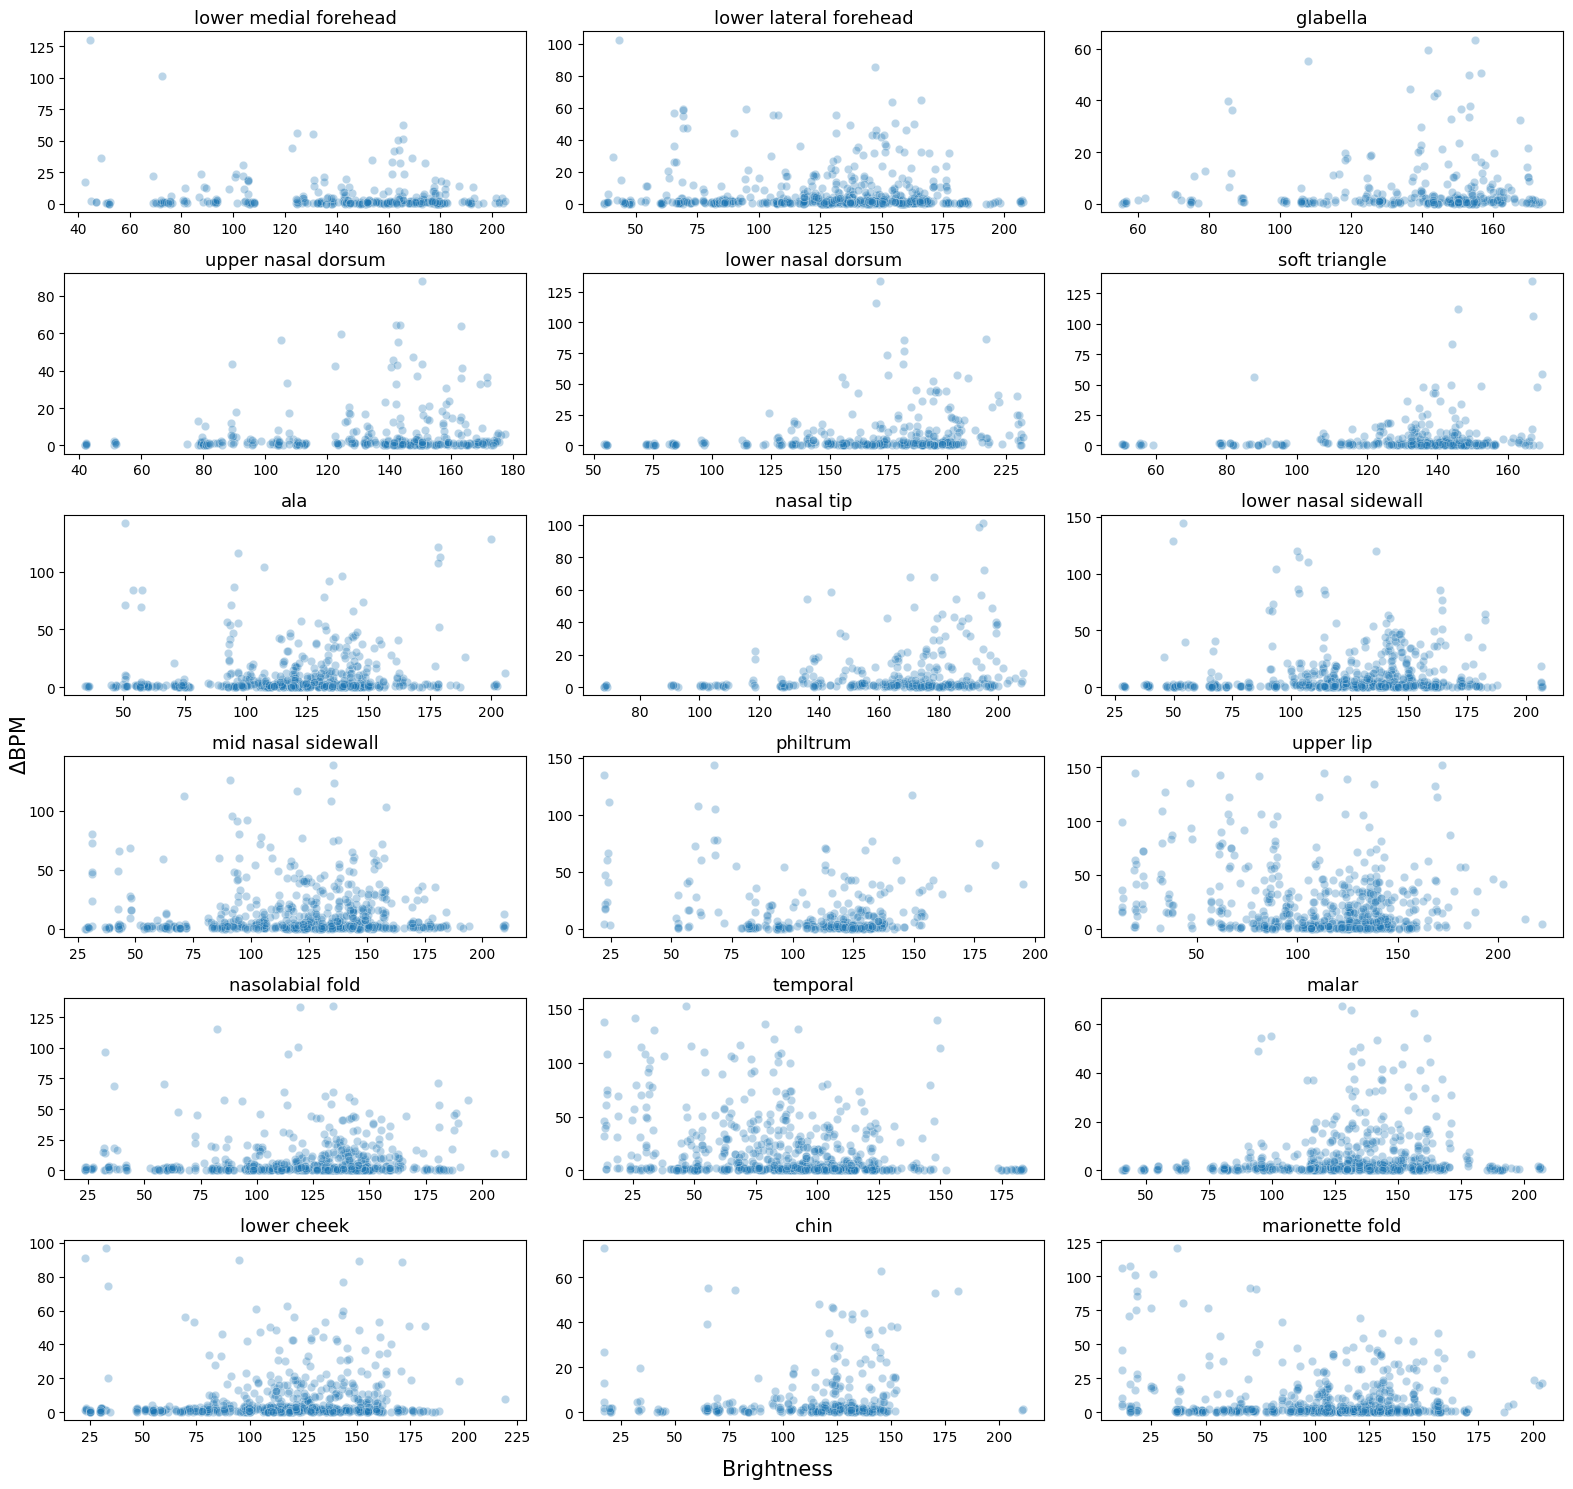

In [54]:
fig, ax = plt.subplots(6,3, figsize=(16,15))
for i, landmark in enumerate(df['landmarks'].unique()):
    x = df.query(f'landmarks == "{landmark}"')
    sns.scatterplot(x='ldmk_brightness', y='AE', data=x, ax=ax[i//3, i%3], markers='x', alpha=0.3)
    ax[i//3, i%3].set_title(landmark.replace('_', ' '), fontsize=13)
    ax[i//3, i%3].set_xlabel('')
    ax[i//3, i%3].set_ylabel('')
fig.supylabel(r'$\Delta$BPM',fontsize=15)
fig.supxlabel('Brightness', fontsize=15)
fig.tight_layout()
plt.show()

In [ ]:
import plotly.express as px
# plot roi_brightness on x axis with the MAE on y axis, color coded by landmarks
fig = px.scatter(df, x='ldmk_brightness', y='AE', color='landmarks', hover_data=['landmarks'])
fig.show()

## By video

In [55]:
import ast 

df_roi, df = pd.DataFrame(), pd.DataFrame()
# for dataset_name in ['LGI_PPGI', 'MR_NIRP']:
for dataset_name in DATASETS:
    df_roi = pd.read_csv(f'../results/no_overlap/{dataset_name}/roi_brightness.csv')
    df_video = pd.read_csv(f'../results/no_overlap/{dataset_name}/face_brightness.csv')
    for roi in df_roi.columns[2:]:
        df_roi[roi] = df_roi[roi].apply(lambda x: np.mean(ast.literal_eval(x)))

    tmp = pd.read_hdf(f'../results/no_overlap/{dataset_name}/{SAMPLING}/{dataset_name}_28.h5').drop(columns=['BVP_win', 'timeGT', 'config'])
    tmp['landmarks'] = tmp['landmarks'].apply(lambda x: x[0])
    # merge df_roi to df by matching values in the column 'landmarks' in df to the column names in df_roi
    tmp = tmp.merge(df_roi.melt(id_vars=['videoFilename','dataset'], var_name='landmarks', value_name='ldmk_brightness'), on=['dataset','videoFilename', 'landmarks'], how='left')
    tmp = tmp.merge(df_video.rename({'brightness':'video_brightness'},axis=1), on=['videoFilename','dataset'], how='left')
    df = pd.concat([df, tmp], ignore_index=True)

df['MAE'] = df['MAE'].apply(lambda x: x[0])
datasets = df['dataset'].unique()
df['datasets'] = df['dataset'].apply(lambda x: datasets)

# # for now just consider resting 
df = get_pruned(df)

# rename the left and right components as one landmark
df['landmarks'] = df['landmarks'].apply(lambda x: x.replace('left_', '').replace('right_', ''))

# bin brightness values and calculate the average MAE for each bin
df['ldmk_brightness_bin'] = pd.cut(df['ldmk_brightness'], bins=[0,100,140,220], labels=['-100', '100-140','140-'], right=False)
df['mae_brightness_bin'] = df.groupby(['landmarks', 'ldmk_brightness_bin'])['MAE'].transform('median').apply(lambda x: round(x, 2))

# groupby landmarks, ldmk_brightness_bin that gave the best MAE on average
ldmk_best_brightness = df.groupby(['landmarks', 'ldmk_brightness_bin'])['MAE'].mean().unstack().idxmin(axis=1).reset_index(name='best_ldmk_brightness')
df = df.merge(ldmk_best_brightness, on='landmarks', how='left')
brightness_target = {'-100':80, '140-':160, '100-140':120}
df['target'] = df['best_ldmk_brightness'].apply(lambda x: brightness_target[x])

df.head(1)

,dataset,videoIdx,videoFilename,method,landmarks,bpmGT,bpmES,timeES,RMSE,MAE,...,timeDTW,SNR,ROI,ldmk_brightness,video_brightness,datasets,ldmk_brightness_bin,mae_brightness_bin,best_ldmk_brightness,target
0,lgi_ppgi,0,alex_gym,cupy_CHROM,lower_medial_forehead,"[100.0, 99.5, 97.0, 94.5, 93.5, 93.0, 93.5, 94...","[50.537109375, 104.736328125, 126.708984375, 1...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]",[19.20279927775441],11.500651,...,2.009835,[-4.055627882480621],forehead,121.594144,105.685542,"[lgi_ppgi, mr_nirp, ubfc_phys]",100-140,5.74,140-,160


In [56]:
df.query('ldmk_brightness_bin == best_ldmk_brightness', engine='python').drop_duplicates(['landmarks'])[['landmarks', 'best_ldmk_brightness', 'mae_brightness_bin', 'target']]

,landmarks,best_ldmk_brightness,mae_brightness_bin,target
1,lower_lateral_forehead,100-140,4.88,120
3,glabella,100-140,3.91,120
7,ala,100-140,6.42,120
9,nasal_tip,100-140,1.71,120
10,lower_nasal_sidewall,100-140,5.99,120
14,philtrum,100-140,7.70,120
15,upper_lip,100-140,13.16,120
20,temporal,100-140,6.92,120
25,chin,100-140,4.06,120
26,marionette_fold,100-140,4.24,120


In [22]:
import plotly.express as px
# plot roi_brightness on x axis with the MAE on y axis, color coded by landmarks
fig = px.scatter(df, x='ldmk_brightness', y='MAE', color='landmarks', hover_data=['landmarks', 'videoFilename'])
fig.show()

In [ ]:
x = df.query('ldmk_brightness_bin == best_ldmk_brightness', engine='python').drop_duplicates(['landmarks'])[['landmarks', 'best_ldmk_brightness', 'mae_brightness_bin', 'target', 'datasets']].copy()
x['target'] = 80
x['datasets'] = 'custom_80'
x.to_csv(f'../results/brightness_roi/roi_80/best_roi_brightness.csv', index=False)

In [ ]:
df.query('ldmk_brightness_bin == best_ldmk_brightness', engine='python').drop_duplicates(['landmarks'])[['landmarks', 'best_ldmk_brightness', 'mae_brightness_bin', 'target', 'datasets']]\
    .to_csv(f'../results/brightness_roi/lgi_mr/best_roi_brightness.csv', index=False)

# Enhanced by ROI

- LGI: Used only LGI videos to get the heuristic for brightness
- LGI-MR: Used LGI and MRNIRP videos 

In [5]:
def __get_df(df):
    df = format_data(df).drop(columns=['config', 'MAE_z', 'PCC_z', 'timePCC_z', 'timeDTW_z', ])
    df = format_data_symmetric_landmark(df, symmetric=False) 
    df['ldmk_MAE'] = df.groupby(['landmarks'])['MAE'].transform('mean')
    df['video_MAE'] = df.groupby(['videoFilename'])['MAE'].transform('mean') 

    return df

def __get_target_brightness(level):
    df_roi = pd.read_csv(f'../results/brightness_roi/{level}/best_roi_brightness.csv')
    roi_brightness = dict([(x['landmarks'], x['target']) for x in df_roi[['landmarks','target']].to_dict('records')])
    ldmk_names = [x for x in list(vhr.extraction.CustomLandmarks().__dict__)]
    roi_brightness = dict([(name, roi_brightness[name.replace('left_', '').replace('right_', '')]) for name in ldmk_names])
    df_roi = pd.DataFrame(list(roi_brightness.items()), columns=['landmarks', 'ldmk_target'])
    df_roi['brightness'] = level    

    return df_roi

def compare_asym_landmarks_brightness(dataset_name, levels = ['lgi', 'lgi_mr'], still=False):
    """
        Plot boxplot of asymmetrical landmarks by brightness levels
        Brightness adjusted by heuristics per ROI
    """
    df = __get_df(pd.read_hdf(f'../results/brightness_roi/LGI_PPGI_28_baseline.h5').query("method == 'cupy_CHROM'"))
    df['brightness'] = 0
    dataset_name = 'LGI_PPGI'

    for level in levels:
        tmp =  __get_df(pd.read_hdf(f'../results/brightness_roi/{level}/{dataset_name}/{dataset_name}_28.h5'))
        tmp['brightness'] = level
        df_roi = __get_target_brightness(level)
        tmp = tmp.merge(df_roi, on=['landmarks', 'brightness'], how='left')
        df = pd.concat([df, tmp], ignore_index=True)
    if still:
        df = get_still(df)
    print("Brightness levels: " , df.brightness.unique())

    groupby_col, metric = ['landmarks', 'brightness'], 'MAE'
    grouped = df[['landmarks', 'brightness','MAE']].groupby(groupby_col).median()
    grouped_original = grouped.reset_index(level=1).query('brightness == 0').copy() # sort by median
    df_good = df[df['landmarks'].isin(top_landmarks_asym)].copy()
    df_bad = df[~df['landmarks'].isin(top_landmarks_asym)].copy()

    def boxplot_landmarks(df, grouped, metric, ax):
        box = sns.boxplot(x='landmarks', y=metric, data=df.sort_values(['ROI', 'brightness']), hue='brightness', ax=ax, showfliers=False,)
        labels = [item.get_text().replace('_', ' ')  for item in box.get_xticklabels()]
        box.set_xticks(range(len(labels)))
        box.set_xticklabels(labels,rotation=90, fontsize=10)
        if metric == 'MAE': metric = r'$\Delta$' + 'BPM'
        if metric == 'timeDTW': metric = 'DTW'
        if metric == 'score': metric = 'OS'
        box.set_xlabel('Landmark')
        box.set_ylabel(metric)
        return box

    fig, ax = plt.subplots(2,1, figsize=(16,8))
    box1 = boxplot_landmarks(df_good, grouped_original.loc[grouped_original.index.get_level_values('landmarks').isin(top_landmarks_asym)], 'MAE', ax[0])
    box2 = boxplot_landmarks(df_bad, grouped_original.loc[~grouped_original.index.get_level_values('landmarks').isin(top_landmarks_asym)], 'MAE', ax[1])
    plt.tight_layout()

    return df, grouped, fig

In [6]:
df.query('landmarks == "nasal_tip"').drop_duplicates('brightness')

NameError: name 'df' is not defined

Brightness levels:  [0 'lgi' 'lgi_mr']


landmarks brightness        MAE           
                                                  mean     median
0                       glabella          0   7.840095   3.355794
1          lower_medial_forehead          0   8.690740   6.675293
2   right_lower_lateral_forehead          0   9.010062   5.060221
3                    right_malar          0  10.111802   5.249023
4              right_lower_cheek          0  12.100630   6.128092
5    left_lower_lateral_forehead          0  12.596561   7.790690
7                           chin          0  12.896262   8.296387
8             upper_nasal_dorsum          0  12.903927   9.427572
9                     left_malar          0  12.964341   9.875000
13         right_marionette_fold          0  14.361565  11.736491
15                     nasal_tip     lgi_mr  15.227901  13.163411
18         right_nasolabial_fold     lgi_mr  15.550673  16.909180
20              left_lower_cheek          0  15.668649  14.147298
21                      philtrum     lgi_mr  15.867296  14.356120
22    right_lower_nasal_sidewall     lgi_mr  16.335684  15.242513
24                 soft_triangle     lgi_mr  17.027416  16.011068
27                left_upper_lip     lgi_mr  17.451208  18.724935
31      right_mid_nasal_sidewall     lgi_mr  17.916305  17.998372
35          left_nasolabial_fold     lgi_mr  18.726924  17.027995
39          left_marionette_fold          0  19.187589  20.575358
40                right_temporal     lgi_mr  19.376989  18.402018
42               right_upper_lip     lgi_mr  20.654586  19.509115
43                     right_ala     lgi_mr  20.977792  21.226237
50            lower_nasal_dorsum          0  22.107363  19.366048
52       left_mid_nasal_sidewall        lgi  22.411811  20.452474
55                 left_temporal     lgi_mr  22.485062  21.477214
56     left_lower_nasal_sidewall     lgi_mr  22.557798  21.017904
64                      left_ala     lgi_mr  24.096029  17.180990

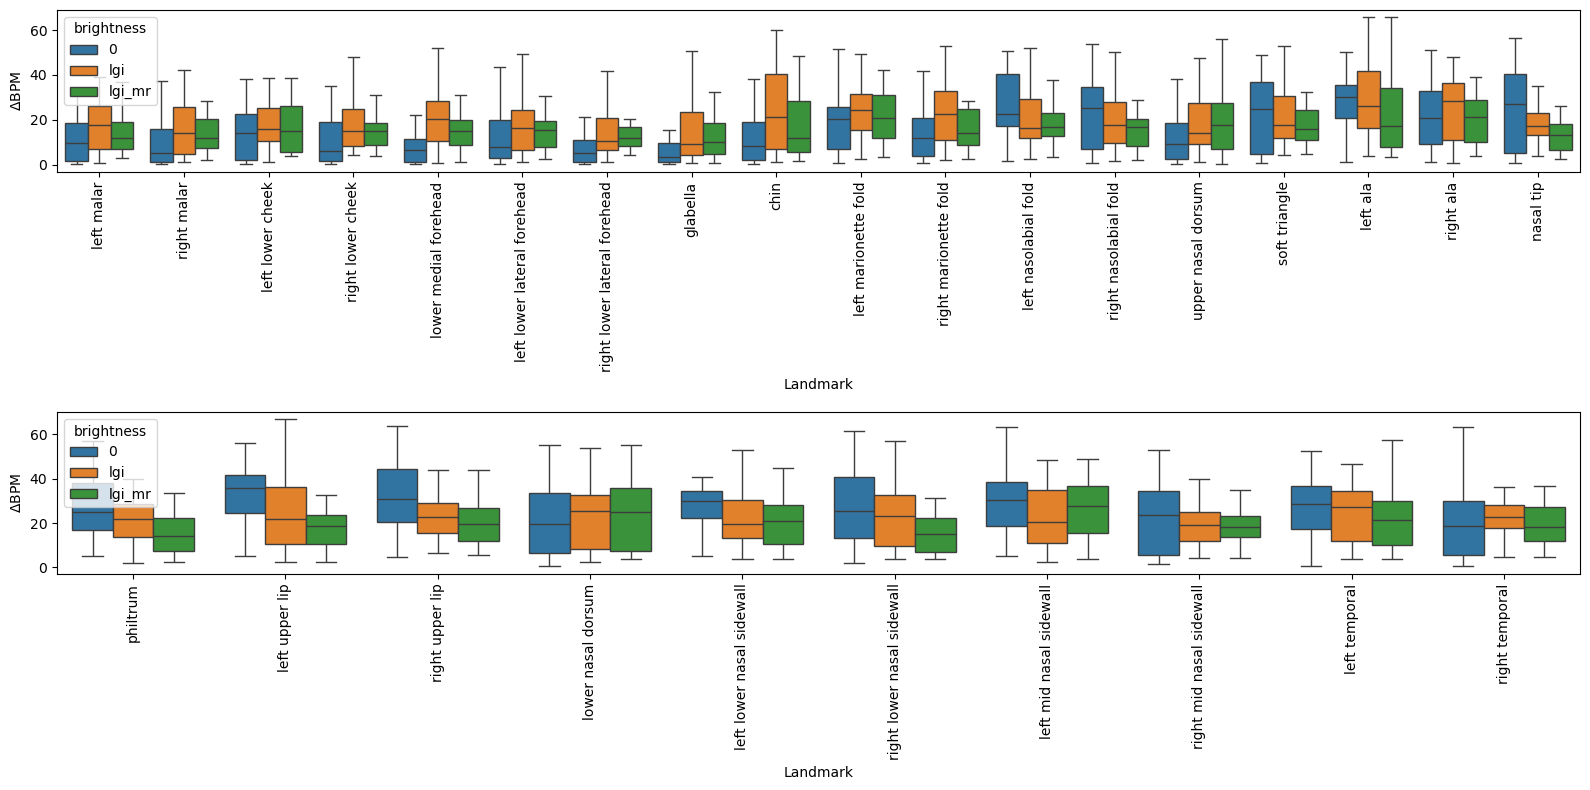

In [ ]:
df, grouped, fig = compare_asym_landmarks_brightness('LGI_PPGI', levels = ['lgi', 'lgi_mr'])
df[['landmarks', 'brightness','MAE']].groupby(['landmarks', 'brightness']).agg(['mean', 'median']).sort_values(by=('MAE', 'mean')).reset_index().groupby('landmarks').head(1) # mean
# grouped.reset_index().sort_values(by='MAE').drop_duplicates(subset='landmarks', keep='first') # median
# df[['landmarks', 'brightness','MAE']].groupby(['landmarks', 'brightness']).apply('mean').reset_index().sort_values(by=['landmarks','brightness']).query('landmarks == "marionette_fold"') # check

Brightness levels:  [0 'lgi' 'lgi_mr']


landmarks brightness        MAE           
                                                  mean     median
0          lower_medial_forehead          0   1.437880   0.778646
1   right_lower_lateral_forehead          0   1.473253   0.707031
2                       glabella          0   1.632704   0.997396
3                           chin          0   1.655273   0.980794
4                    right_malar          0   1.656521   1.023926
5               left_lower_cheek          0   1.715983   0.955241
6    left_lower_lateral_forehead          0   2.243218   1.003255
7                     left_malar          0   2.311686   1.393229
8          right_marionette_fold          0   3.278049   2.901204
9              right_lower_cheek          0   4.162381   1.152669
11      right_mid_nasal_sidewall          0   5.423828   5.235840
15            upper_nasal_dorsum          0   6.015516   1.091634
18                      philtrum     lgi_mr   6.684353   7.229818
20          left_marionette_fold          0   9.224826   3.901530
21         right_nasolabial_fold     lgi_mr   9.246311   7.620117
25                     nasal_tip     lgi_mr   9.460178   9.486328
26                     right_ala        lgi   9.532010  10.641276
28            lower_nasal_dorsum        lgi   9.787109   8.260091
31     left_lower_nasal_sidewall     lgi_mr  10.063585   8.789062
32    right_lower_nasal_sidewall        lgi  10.094944   9.483073
35                 soft_triangle        lgi  10.545030  10.688802
39                 left_temporal     lgi_mr  11.459418   8.605143
43                right_temporal          0  11.952257   0.959147
60       left_mid_nasal_sidewall        lgi  14.227865   6.364583
62          left_nasolabial_fold        lgi  14.707031  11.471354
65               right_upper_lip     lgi_mr  16.762912  17.507812
66                      left_ala     lgi_mr  16.985894  12.765625
70                left_upper_lip     lgi_mr  18.369683  17.111654

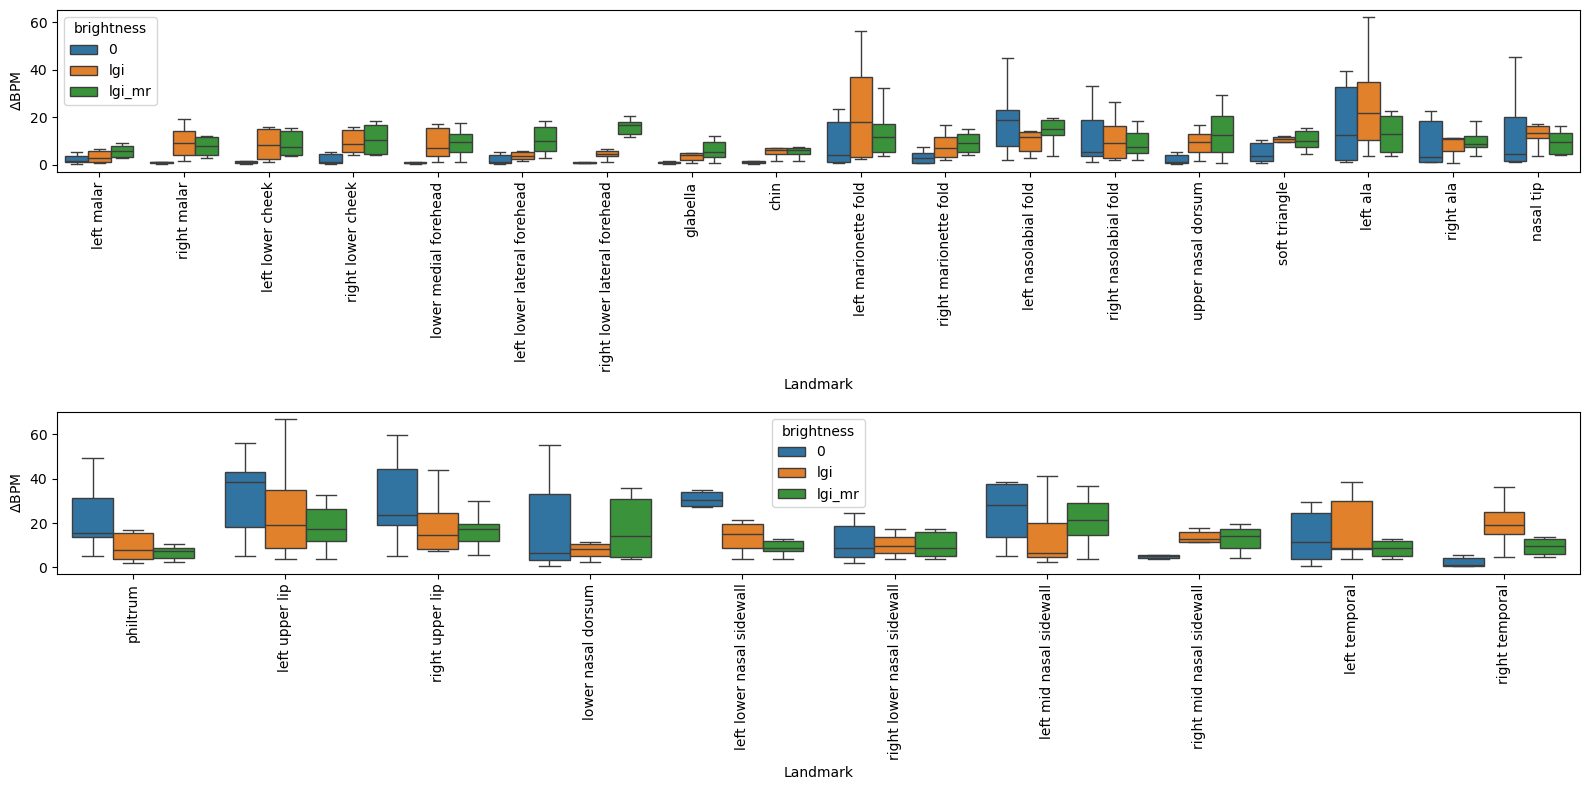

In [ ]:
# still
df, grouped, fig = compare_asym_landmarks_brightness('LGI_PPGI', levels = ['lgi', 'lgi_mr'], still=True)
df[['landmarks', 'brightness','MAE']].groupby(['landmarks', 'brightness']).agg(['mean', 'median']).sort_values(by=('MAE', 'mean')).reset_index().groupby('landmarks').head(1) # mean
# grouped.reset_index().sort_values(by='MAE').drop_duplicates(subset='landmarks', keep='first') # median
# df[['landmarks', 'brightness','MAE']].groupby(['landmarks', 'brightness']).apply('mean').reset_index().sort_values(by=['landmarks','brightness']).query('landmarks == "marionette_fold"') # check

# Enhanced by ROI 2 

- Adjust each ROI to arbitrary brightness level

In [ ]:
res = df[['landmarks', 'brightness','MAE']].groupby(['landmarks', 'brightness']).agg(['mean', 'median']).sort_values(by=('MAE', 'mean')).reset_index()
res[res['landmarks'].isin(['soft_triangle', 'chin'])]

landmarks brightness        MAE           
                                   mean     median
6            chin          0  12.896262   8.296387
27           chin    roi_120  19.713650  23.236654
28           chin    roi_160  19.737956  14.940755
41  soft_triangle          0  21.196452  24.856608
46  soft_triangle    roi_120  21.525960  17.894206
58  soft_triangle    roi_160  22.828179  27.004557

Brightness levels:  [0 'roi_120' 'roi_160']


landmarks brightness        MAE           
                                                  mean     median
0                       glabella          0   7.840095   3.355794
1          lower_medial_forehead          0   8.690740   6.675293
2   right_lower_lateral_forehead          0   9.010062   5.060221
3                    right_malar          0  10.111802   5.249023
4              right_lower_cheek          0  12.100630   6.128092
5    left_lower_lateral_forehead          0  12.596561   7.790690
6                           chin          0  12.896262   8.296387
7             upper_nasal_dorsum          0  12.903927   9.427572
8                     left_malar          0  12.964341   9.875000
9          right_marionette_fold          0  14.361565  11.736491
11              left_lower_cheek          0  15.668649  14.147298
19       left_mid_nasal_sidewall    roi_160  18.808919  16.319987
20          left_marionette_fold          0  19.187589  20.575358
21                right_temporal    roi_120  19.381321  18.902344
22                     nasal_tip    roi_160  19.399441  17.948893
23                     right_ala    roi_120  19.491943  20.198242
30                      left_ala    roi_120  19.908529  16.071615
31         right_nasolabial_fold    roi_120  19.964301  20.119466
32            lower_nasal_dorsum    roi_160  20.219971  20.720052
39      right_mid_nasal_sidewall    roi_160  21.026991  18.568685
41                 soft_triangle          0  21.196452  24.856608
42                 left_temporal    roi_120  21.384738  17.710612
48                left_upper_lip    roi_120  21.998806  20.641276
49    right_lower_nasal_sidewall    roi_160  22.024794  21.799154
59     left_lower_nasal_sidewall    roi_120  22.891737  24.855143
60                      philtrum    roi_120  23.212375  21.633464
62          left_nasolabial_fold    roi_120  23.668267  20.180339
65               right_upper_lip    roi_120  24.088108  20.839844

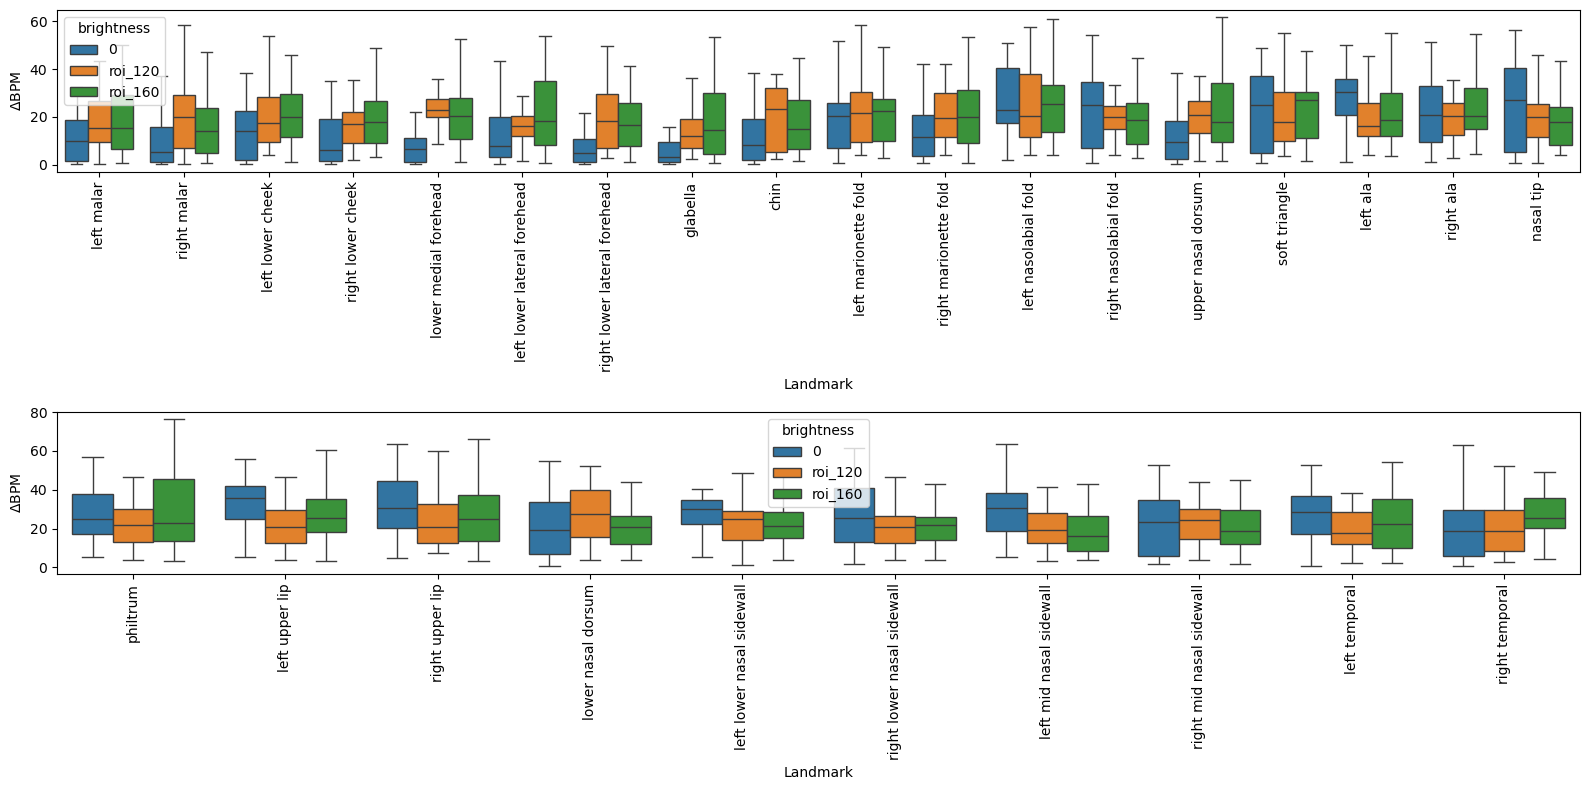

In [ ]:
df, grouped, fig = compare_asym_landmarks_brightness('LGI_PPGI',levels = ['roi_120', 'roi_160'])
df[['landmarks', 'brightness','MAE']].groupby(['landmarks', 'brightness']).agg(['mean', 'median']).sort_values(by=('MAE', 'mean')).reset_index().groupby('landmarks').head(1) # mean
# grouped.reset_index().sort_values(by='MAE').drop_duplicates(subset='landmarks', keep='first') # median
# df[['landmarks', 'brightness','MAE']].groupby(['landmarks', 'brightness']).apply('mean').reset_index().sort_values(by=['landmarks','brightness']).query('landmarks == "marionette_fold"') # check

Brightness levels:  [0 'roi_120' 'roi_160']


landmarks brightness        MAE           
                                                  mean     median
0          lower_medial_forehead          0   1.437880   0.778646
1   right_lower_lateral_forehead          0   1.473253   0.707031
2                       glabella          0   1.632704   0.997396
3                           chin          0   1.655273   0.980794
4                    right_malar          0   1.656521   1.023926
5               left_lower_cheek          0   1.715983   0.955241
6    left_lower_lateral_forehead          0   2.243218   1.003255
7                     left_malar          0   2.311686   1.393229
8          right_marionette_fold          0   3.278049   2.901204
9              right_lower_cheek          0   4.162381   1.152669
11      right_mid_nasal_sidewall          0   5.423828   5.235840
12            upper_nasal_dorsum          0   6.015516   1.091634
23          left_marionette_fold          0   9.224826   3.901530
28     left_lower_nasal_sidewall    roi_160  10.072049   8.446289
30       left_mid_nasal_sidewall    roi_160  10.214410   7.380208
31                 soft_triangle          0  10.605686   3.483398
32                      left_ala    roi_120  10.726237  10.292969
33                     nasal_tip    roi_160  10.800022   7.635742
34                right_temporal    roi_120  10.902452   6.845378
35    right_lower_nasal_sidewall          0  11.607151   8.928711
38         right_nasolabial_fold          0  11.921007   5.443848
39            lower_nasal_dorsum    roi_120  11.931207   9.950195
48                     right_ala    roi_160  13.417643  11.820312
51                 left_temporal          0  13.794651  11.657227
62               right_upper_lip    roi_120  16.395508  16.324544
63                      philtrum    roi_120  16.442274   9.940104
70          left_nasolabial_fold          0  18.845161  18.861165
73                left_upper_lip    roi_160  19.839735  18.983398

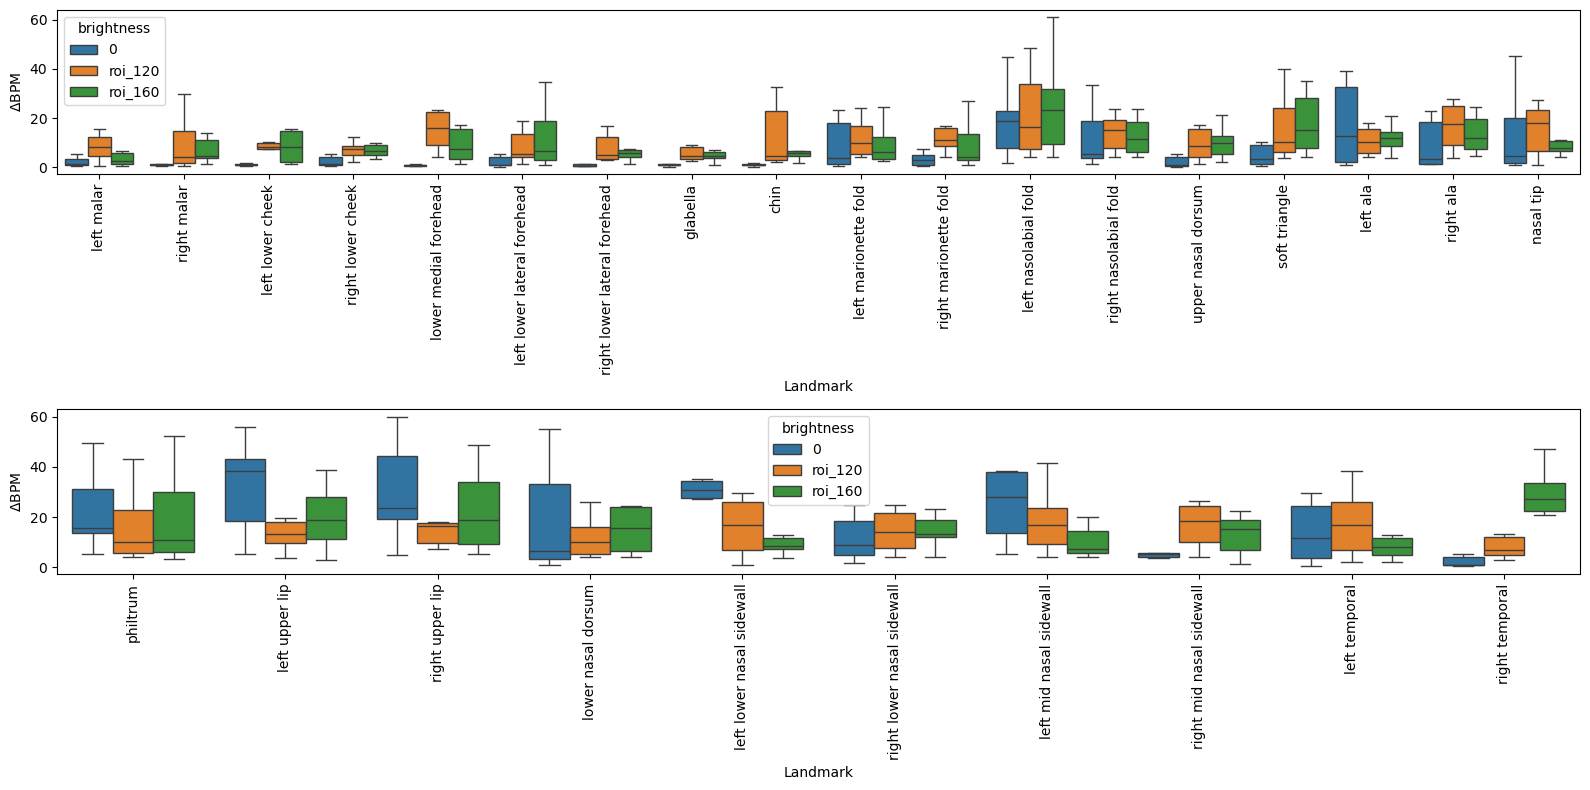

In [ ]:
df, grouped, fig = compare_asym_landmarks_brightness('LGI_PPGI',levels = ['roi_120', 'roi_160'], still=True)
df[['landmarks', 'brightness','MAE']].groupby(['landmarks', 'brightness']).agg(['mean', 'median']).sort_values(by=('MAE', 'mean')).reset_index().groupby('landmarks').head(1) # mean
# grouped.reset_index().sort_values(by='MAE').drop_duplicates(subset='landmarks', keep='first') # median
# df[['landmarks', 'brightness','MAE']].groupby(['landmarks', 'brightness']).apply('mean').reset_index().sort_values(by=['landmarks','brightness']).query('landmarks == "marionette_fold"') # check

# Brightness of video 

In [ ]:
df = pd.DataFrame()
for dataset_name in DATASETS:
    df = pd.concat([df, pd.read_hdf(f'../results/no_overlap/{dataset_name}/{SAMPLING}/{dataset_name}_18.h5')])
print("Sampling - window - overlap: ", df.config.unique())
df = df.query("method == 'cupy_CHROM'") # TODO
df = format_data(df).drop(columns=['config', 'MAE_z', 'PCC_z', 'timePCC_z', 'timeDTW_z', ])
df = format_data_symmetric_landmark(df, symmetric=True) 
df = df[(df['dataset'] == 'lgi_ppgi') & df['videoFilename'].str.contains('resting') | (df['dataset'] == 'mr_nirp') & df['videoFilename'].str.contains('still')
        | (df['dataset'] == 'ubfc_phys')].copy().reset_index(drop=True)

print(df.shape, "ROI: ", df.ROI.unique(), df.ROI.unique().size)
print("Landmarks: ", df.landmarks.unique().size)
df.head(1)

Sampling - window - overlap:  ['2000_win10-0']
(1260, 22) ROI:  ['forehead' 'nose' 'mustache' 'temple' 'cheeks' 'jaw'] 6
Landmarks:  18


,dataset,videoIdx,videoFilename,landmarks,bpmGT,bpmES,timeGT,timeES,BVP_win,RMSE,...,timePCC,timeDTW,SNR,ROI,video,person,FreqScore,TimeScore,score,OS
0,lgi_ppgi,1,alex_resting,lower_medial_forehead,"[68.5, 68.0, 68.0, 67.5, 67.0, 67.0, 66.5, 66....","[68.115234375, 63.720703125, 65.91796875, 68.1...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0]","[[[-0.0018437893949923298, -0.1971926391704808...",[0.6623081145314609],...,0.014376,1.951776,[5.035702139139175],forehead,resting,alex,0.003175,0.655885,0.167383,0.438365


In [ ]:
# Brightness 
df_data = pd.DataFrame()
for dataset_name in DATASETS:
    # df_data = pd.concat([df_data, pd.read_csv(f'../results/no_overlap/{dataset_name}/{dataset_name}_brightness.csv')])
    df_data = pd.concat([df_data, pd.read_csv(f'../results/brightness_60/{dataset_name}/face_brightness.csv')])
df = df.merge(df_data, on=['dataset', 'videoFilename'], how='left')
df_data['dataset'] = df_data['dataset'].apply(lambda x: x.replace('_', '-').upper())
df_data.drop_duplicates('dataset').head()

,dataset,videoFilename,brightness
0,LGI-PPGI,alex_gym,105.685542
0,MR-NIRP,Subject1_still_940,45.029081
0,UBFC-PHYS,s1,104.912960


<AxesSubplot: xlabel='videoFilename'>

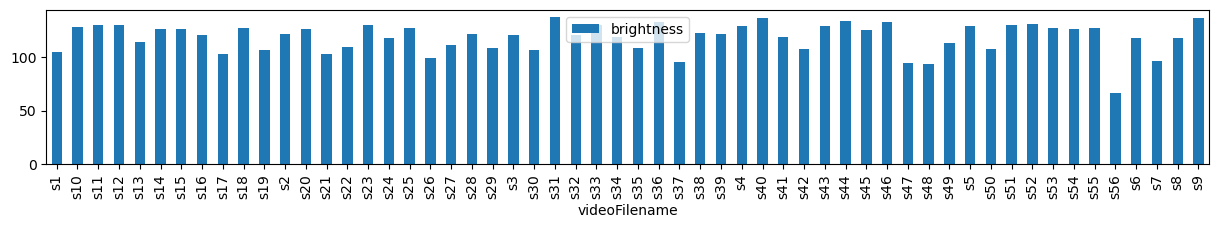

In [ ]:
df_data.query('dataset == "UBFC-PHYS"').plot.bar(y='brightness', x='videoFilename', figsize=(15,2))

C:\Users\erolland\AppData\Local\Temp\3\ipykernel_54116\1220280030.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = tmp.groupby('brightness_bin')['MAE'].agg(['mean', 'std']).reset_index()
C:\Users\erolland\AppData\Local\Temp\3\ipykernel_54116\1220280030.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = tmp.groupby('brightness_bin')['MAE'].agg(['mean', 'std']).reset_index()
C:\Users\erolland\AppData\Local\Temp\3\ipykernel_54116\1220280030.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain c

Text(0, 0.5, '$\\Delta$BPM')

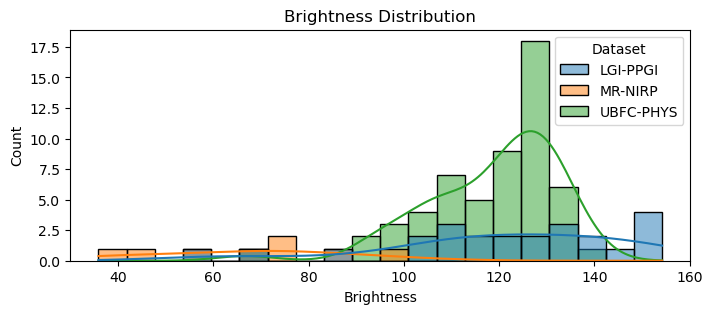

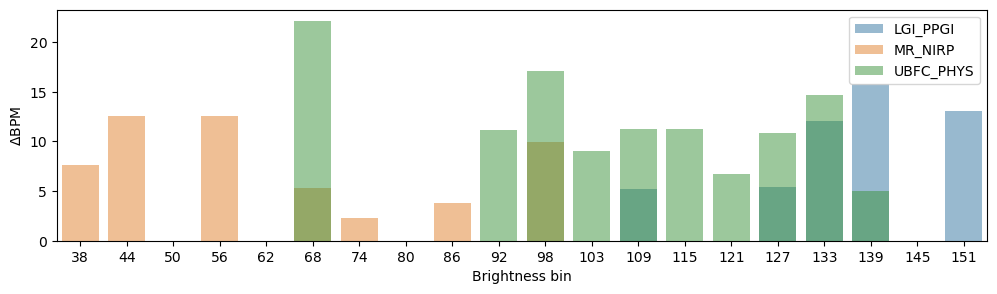

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,3))
sns.histplot(data=df_data.rename(columns={'brightness':'Brightness', 'dataset':'Dataset'}), x='Brightness', hue='Dataset', bins=20, kde=True, ax=ax)
ax.set_title('Brightness Distribution')

fig, ax = plt.subplots(1,1, figsize=(12,3))
bins = 20
df['brightness_bin'] = pd.cut(df['brightness'], bins=bins)
for dataset_name in DATASETS:
    tmp = df.query(f"dataset == '{dataset_name.lower()}'").copy()
    # tmp['brightness_bin'] = pd.cut(tmp['brightness'], bins=bins)
    tmp = tmp.groupby('brightness_bin')['MAE'].agg(['mean', 'std']).reset_index()
    # tmp['std'] = tmp['std'].fillna(0)
    tmp['bin'] = tmp['brightness_bin'].apply(lambda x: int(x.mid)) 

    sns.barplot(x='bin', y='mean', data=tmp, ax=ax, alpha=0.5, label=dataset_name)
ax.set_xlabel('Brightness bin')
ax.set_ylabel(r'$\Delta$' + 'BPM')
# ax.set_xticks([ 40.,  60.,  80., 100., 120., 140., 160., 180., 200., 220.])

C:\Users\erolland\AppData\Local\Temp\3\ipykernel_54116\926202968.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = tmp.groupby('brightness_bin')['MAE'].agg(['mean', 'std']).reset_index()
C:\Users\erolland\AppData\Local\Temp\3\ipykernel_54116\926202968.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = tmp.groupby('brightness_bin')['MAE'].agg(['mean', 'std']).reset_index()
C:\Users\erolland\AppData\Local\Temp\3\ipykernel_54116\926202968.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current

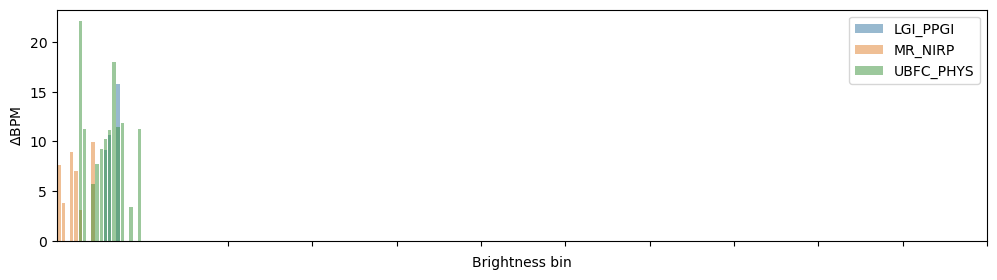

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,3))
bins = 20
df['brightness_bin'] = pd.cut(df['brightness'], bins=bins)
for dataset_name in DATASETS:
    tmp = df.query(f"dataset == '{dataset_name.lower()}'").copy()
    # tmp['brightness_bin'] = pd.cut(tmp['brightness'], bins=bins)
    tmp = tmp.groupby('brightness_bin')['MAE'].agg(['mean', 'std']).reset_index()
    # tmp['std'] = tmp['std'].fillna(0)
    tmp['bin'] = tmp['brightness_bin'].apply(lambda x: int(x.mid)) 

    sns.barplot(x='bin', y='mean', data=tmp, ax=ax, alpha=0.5, label=dataset_name)
ax.set_xlabel('Brightness bin')
ax.set_ylabel(r'$\Delta$' + 'BPM')
ax.set_xticks([ 40.,  60.,  80., 100., 120., 140., 160., 180., 200., 220.])x

C:\Users\erolland\AppData\Local\Temp\3\ipykernel_50976\4154918087.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = tmp.groupby('brightness_bin')['MAE'].agg(['mean', 'std']).reset_index()
C:\Users\erolland\AppData\Local\Temp\3\ipykernel_50976\4154918087.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = tmp.groupby('brightness_bin')['MAE'].agg(['mean', 'std']).reset_index()
C:\Users\erolland\AppData\Local\Temp\3\ipykernel_50976\4154918087.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curr

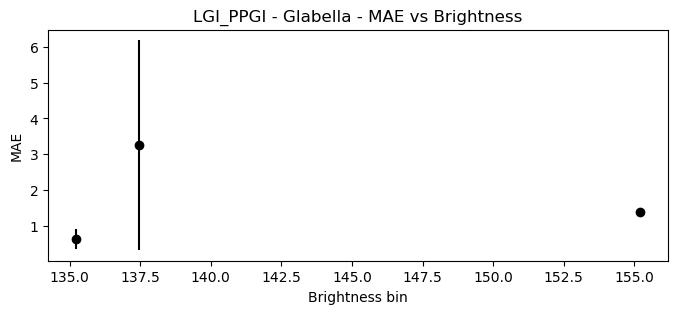

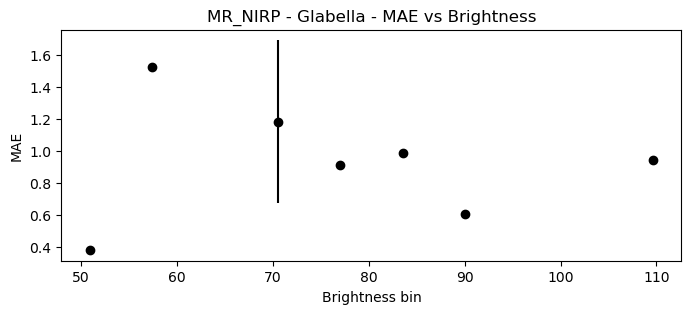

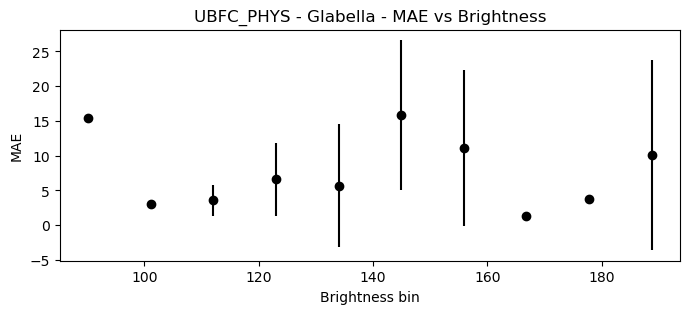

In [ ]:
for dataset_name in DATASETS:
    dataset_name = dataset_name.lower()
    tmp = df.query(f'dataset == "{dataset_name}"').query('landmarks == "glabella"')
    # groupby brightness bin and calculate mean and std of MAE for each bin
    tmp['brightness_bin'] = pd.cut(tmp['brightness'], bins=10)
    tmp = tmp.groupby('brightness_bin')['MAE'].agg(['mean', 'std']).reset_index()
    tmp['std'] = tmp['std'].fillna(0)
    tmp['bin'] = tmp['brightness_bin'].apply(lambda x: x.mid) 
    fig, ax = plt.subplots(1,1, figsize=(8,3))
    ax.errorbar(x=tmp['bin'], y=tmp['mean'], yerr=tmp['std'], fmt='o', color='black', capsize=0)
    ax.set_xlabel('Brightness bin')
    ax.set_ylabel('MAE')
    ax.set_title(f'{dataset_name.upper()} - Glabella - MAE vs Brightness')

# plot histogram with brightness bins as x axis
# fig, ax = plt.subplots(1,1, figsize=(8,3))
# sns.histplot(data=tmp, x='brightness_bin', y='mean', bins=50, kde=True, ax=ax)
